<a href="https://colab.research.google.com/github/chebyshevtech/hybridselftalk/blob/main/ToTMath_Kingsley.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Numerical LLM solver

Nodes:   0%|          | 0/600 [?node/s]

[d=0] V=0.00 τ=-0.20 facts=0
[d=10] V=28.10 τ=-0.20 facts=13

=== RESULTS (Depth-weighted voting over entire tree) ===
Deepest depth (dmax): 14
All candidate answers (sorted by total weight):
  ANSWER=  11 | total_weight=1.429841 | count=149 | depth_range=[1, 14]
      - node    2 @ d=1   w=0.135335
      - node    3 @ d=1   w=0.135335
      - node    4 @ d=1   w=0.135335
      - node    5 @ d=1   w=0.135335
      - node    6 @ d=1   w=0.135335
      - node    6 @ d=1   w=0.135335
  ANSWER=   3 | total_weight=0.213963 | count= 72 | depth_range=[1, 14]
      - node    1 @ d=1   w=0.135335
      - node   11 @ d=2   w=0.018316
      - node   12 @ d=2   w=0.018316
      - node   15 @ d=2   w=0.018316
      - node   16 @ d=2   w=0.018316
      - node   25 @ d=3   w=0.002479
  ANSWER=   1 | total_weight=0.135335 | count=  9 | depth_range=[1, 14]
      - node    7 @ d=1   w=0.135335
      - node   91 @ d=10  w=0.000000
      - node   98 @ d=10  w=0.000000
      - node  107 @ d=11  w=0.000000


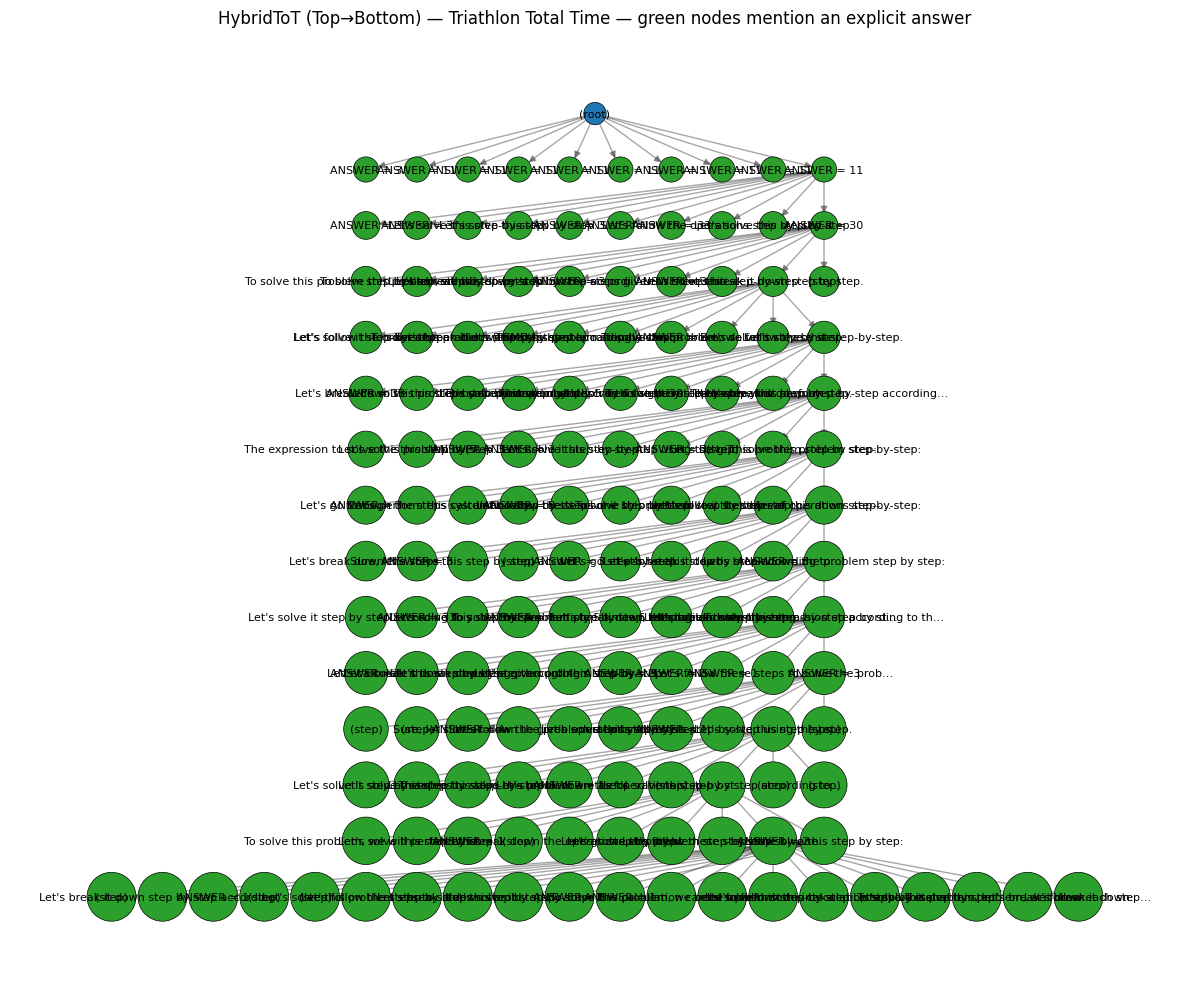


Usage: {'completion_tokens': 14357, 'prompt_tokens': 4200, 'cost': 0.0, 'backend': 'hf-local'}


In [ ]:
# pip install transformers accelerate torch tqdm networkx matplotlib backoff
# (optional) pip install pygraphviz

import os, re, math, random, time, gc, backoff, inspect
from dataclasses import dataclass
from typing import List, Tuple, Optional, Dict
from collections import Counter, deque, defaultdict

try:
    import numpy as np
except Exception:
    np = None

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm.auto import tqdm
import networkx as nx
import matplotlib.pyplot as plt

# ================= Config =================
# Default to HuggyLlama; override with env HUGGY_MODEL if you like
MODEL_NAME = os.getenv("QWEN_MODEL", "Qwen/Qwen2.5-1.5B-Instruct")
# MODEL_NAME = os.getenv("QWEN_MODEL", "Qwen/Qwen2.5-7B-Instruct")
DEVICE_MAP = "auto"
MAX_INPUT_TOKENS = 1024
VOTE_T = 0.5                # depth-weighted voting temperature for w = exp(-di / t)
DEFAULT_SEED = 777          # set None for non-deterministic

# ================= Seeding =================
GENERATOR = None            # used only if model.generate supports it

def set_seed(seed: Optional[int]):
    global GENERATOR
    if seed is None:
        GENERATOR = None
        return
    random.seed(seed)
    if np is not None:
        np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        gen_device = "cuda"
    else:
        gen_device = "cpu"
    GENERATOR = torch.Generator(device=gen_device)
    GENERATOR.manual_seed(seed)

# ================= Model load =================
gc.collect()
if torch.cuda.is_available(): torch.cuda.empty_cache()

tok = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
if tok.pad_token is None: tok.pad_token = tok.eos_token

mdl = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME, device_map=DEVICE_MAP, torch_dtype="auto", trust_remote_code=True
).eval()

def _supports_kwarg(fn, name: str) -> bool:
    try:
        sig = inspect.signature(fn)
        return name in sig.parameters
    except (TypeError, ValueError):
        return False

SUPPORTS_GENERATOR = _supports_kwarg(mdl.generate, "generator")

# ================= HF "chat-like" wrappers =================
completion_tokens = 0
prompt_tokens = 0

def _messages_to_text(messages: List[Dict[str, str]]) -> str:
    # Simple role-tagged transcript; works with most instruct models
    parts = []
    for m in messages:
        role = (m.get("role") or "user").upper()
        content = m.get("content","")
        parts.append(f"{role}: {content}")
    return "\n".join(parts) + "\nASSISTANT:"

# Only backoff on transient runtime errors, not ValueError (argument mismatch)
@backoff.on_exception(backoff.expo, (RuntimeError,), max_tries=5)
def _hf_generate(prompt_text: str, temperature: float, max_tokens: int, n: int, stop=None) -> List[str]:
    global completion_tokens, prompt_tokens
    enc = tok(prompt_text, return_tensors="pt", truncation=True, max_length=MAX_INPUT_TOKENS)
    enc = {k: v.to(mdl.device) for k, v in enc.items()}
    outputs = []
    batch = min(4, n)
    total = n
    while total > 0:
        cnt = min(batch, total); total -= cnt
        bi = {k: v.repeat(cnt, 1) for k, v in enc.items()}
        gen_kwargs = dict(
            do_sample=True, temperature=temperature, top_p=0.92, top_k=60,
            max_new_tokens=max_tokens, pad_token_id=tok.eos_token_id, eos_token_id=tok.eos_token_id,
            num_return_sequences=1,
        )
        if SUPPORTS_GENERATOR and GENERATOR is not None:
            gen_kwargs["generator"] = GENERATOR  # only if supported

        with torch.no_grad():
            gens = mdl.generate(**bi, **gen_kwargs)

        for i in range(cnt):
            txt = tok.decode(gens[i], skip_special_tokens=True)
            gen = txt[len(prompt_text):] if txt.startswith(prompt_text) else txt
            if stop:
                cut = len(gen)
                for s in stop:
                    k = gen.find(s)
                    if k != -1: cut = min(cut, k)
                gen = gen[:cut]
            prompt_tokens += len(tok.encode(prompt_text))
            completion_tokens += len(tok.encode(gen))
            outputs.append(gen.strip())
        if torch.cuda.is_available(): torch.cuda.empty_cache()
    return outputs

def chat_hf(messages, temperature=0.7, max_tokens=256, n=1, stop=None) -> list:
    prompt_text = _messages_to_text(messages)
    return _hf_generate(prompt_text, temperature=temperature, max_tokens=max_tokens, n=n, stop=stop)

def hf(prompt, temperature=0.7, max_tokens=256, n=1, stop=None) -> list:
    messages = [{"role": "user", "content": prompt}]
    return chat_hf(messages, temperature=temperature, max_tokens=max_tokens, n=n, stop=stop)

def hf_usage(backend="hf-local"):
    global completion_tokens, prompt_tokens
    return {"completion_tokens": completion_tokens, "prompt_tokens": prompt_tokens, "cost": 0.0, "backend": backend}

def sample(prompt: str, n: int, max_new_tokens=96, temperature=0.9) -> List[str]:
    return hf(prompt, temperature=temperature, max_tokens=max_new_tokens, n=n, stop=None)

# ================= Parsing helpers =================
ANSWER_RXES = [
    re.compile(r"\bANSWER\s*[:=]\s*(\d{1,4})\b", re.I),
    re.compile(r"\bfinal\s+answer(?:\s+is)?\s*[:=]?\s*(\d{1,4})\b", re.I),
    re.compile(r"\bthe\s+answer\s+is\s+(\d{1,4})\b", re.I),
    re.compile(r"\bresult\s+is\s+(\d{1,4})\b", re.I),
    re.compile(r"\bresult[:=]\s*(\d{1,4})\b", re.I),
]

def extract_integers(text: str) -> List[int]:
    ints = [int(x) for x in re.findall(r"\b(\d{1,4})\b", text)]
    return [v for v in ints if 0 <= v <= 10000]

def parse_answer_candidates(text: str) -> List[int]:
    out = []
    for rx in ANSWER_RXES:
        m = rx.search(text)
        if m:
            out.append(int(m.group(1)))
    if not out:
        ints = extract_integers(text)
        if ints:
            out.append(ints[-1])  # heuristic: final number in snippet
    seen=set(); cleaned=[]
    for v in out:
        if v not in seen:
            seen.add(v); cleaned.append(v)
    return cleaned

def read_answers_from_info(info: Tuple[str, ...]) -> List[int]:
    vals=[]
    for s in info:
        vals += parse_answer_candidates(s)
    return [v for v in vals if 0 <= v <= 10000]

def canon(infos: List[str])->Tuple[str,...]:
    out,seen=[],set()
    for s in infos:
        t=s.strip(); k=t.lower()
        if t and k not in seen:
            seen.add(k); out.append(t[:240])
    return tuple(sorted(out))

# ================= Tree recorder & viz =================
class TreeBook:
    def __init__(self):
        self.G = nx.DiGraph()
        self.next_id = 0
        self.attrs: Dict[int, Dict[str, object]] = {}
        self.info: Dict[int, Tuple[str,...]] = {}
    def add_node(self, depth:int, label:str, info:Tuple[str,...]) -> int:
        nid = self.next_id; self.next_id += 1
        self.G.add_node(nid); self.attrs[nid] = {"depth": depth, "label": label}; self.info[nid] = info
        return nid
    def add_edge(self, u:int, v:int): self.G.add_edge(u, v)

def _graphviz_tb(G):
    try:
        from networkx.drawing.nx_agraph import graphviz_layout
        return graphviz_layout(G, prog="dot", args="-Grankdir=TB")
    except Exception:
        return None

def _layered_tb(G, attrs):
    levels: Dict[int, List[int]] = {}
    for n in G.nodes():
        d = attrs[n]["depth"]
        levels.setdefault(d, []).append(n)
    pos = {}
    y_gap = 1.8
    x_gap = 1.6
    for d in sorted(levels.keys()):
        row = sorted(levels[d])
        width = (len(row)-1)*x_gap
        for i, nid in enumerate(row):
            x = -width/2 + i*x_gap
            y = -d*y_gap
            pos[nid] = (x, y)
    return pos

def plot_tree(tb: TreeBook, title="LLM Search Tree (Top→Bottom)"):
    if tb.G.number_of_nodes()==0:
        print("[viz] Empty tree."); return
    pos = _graphviz_tb(tb.G) or _layered_tb(tb.G, tb.attrs)
    colors, sizes, labels = [], [], {}
    for nid in tb.G.nodes():
        has_ans = any(("ANSWER" in s.upper() or re.search(r"\bfinal\s+answer\b", s, re.I)) for s in tb.info[nid])
        colors.append("#2ca02c" if has_ans else "#1f77b4")
        d = tb.attrs[nid]["depth"]; sizes.append(260 + 70*d)
        lbl = tb.attrs[nid]["label"] or "(root)"
        labels[nid] = (lbl[:42]+"…") if len(lbl)>43 else lbl
    plt.figure(figsize=(12, 10))
    nx.draw_networkx_edges(tb.G, pos, alpha=0.35, arrows=True, arrowstyle="-|>", min_target_margin=8)
    nx.draw_networkx_nodes(tb.G, pos, node_color=colors, node_size=sizes, linewidths=0.5, edgecolors="k")
    nx.draw_networkx_labels(tb.G, pos, labels=labels, font_size=8)
    plt.title(title + " — green nodes mention an explicit answer")
    plt.axis("off"); plt.tight_layout(); plt.show()

# ============== Depth-weighted voting across the whole tree ==============
def depth_weighted_vote(tb: TreeBook, t: float = 2.0):
    """
    Vote(x; t) = sum_{nodes i with answer x} exp(- d_i / t)
      where d_i is the node's depth (root = 0).
    Returns (voted, weights, dmax, contributions)
    """
    if tb.G.number_of_nodes() == 0:
        return None, {}, 0, {}

    dmax = max(tb.attrs[n]["depth"] for n in tb.G.nodes())
    weights = defaultdict(float)
    contributions: Dict[int, List[Tuple[int,int,float]]] = defaultdict(list)

    for nid in tb.G.nodes():
        di = tb.attrs[nid]["depth"]
        answers = read_answers_from_info(tb.info[nid])
        if not answers:
            continue
        w = math.exp(- (di) / max(1e-6, t))   # w = exp(-di / t)
        for x in answers:
            weights[x] += w
            contributions[x].append((nid, di, w))

    if not weights:
        return None, {}, dmax, {}

    voted = max(weights.items(), key=lambda kv: kv[1])[0]
    return voted, dict(weights), dmax, contributions

# ================= Hybrid (DFS + BFS) solver =================
@dataclass
class P:
    max_depth:int=14
    max_nodes:int=600
    min_commit_nodes:int=150
    patience:int=3
    branch:int=18
    T:float=1.6
    bfs_nodes:int=400
    bfs_depth:int=4
    bfs_branch:int=14
    width:int=10
    temp:float=0.95

@dataclass
class Ctrl:
    tau:float=0.0
    eta:float=0.35
    tau_min:float=-1.0
    tau_max:float=6.0
    L_target:float=5.0
    def upd(self,L): self.tau=max(self.tau_min,min(self.tau_max,self.tau+self.eta*(L-self.L_target)))

@dataclass
class Node:
    nid:int; info:Tuple[str,...]; depth:int; value:float; parent:float; H:float=0.0

class HybridToT:
    def __init__(self, p:P):
        self.p=p; self.ctrl=Ctrl(); self.ne=0; self.sv=0; self.vd={}; self.tb=TreeBook()
        self.pending_best = None

    def _H(self, vals):
        if not vals: return 0.0
        T=max(1e-6,self.p.T); m=max(vals); ex=[math.exp((v-m)/T) for v in vals]; Z=sum(ex); ps=[e/max(Z,1e-12) for e in ex]
        return -sum(p*math.log(max(p,1e-12)) for p in ps)

    def _expand(self, problem_text: str, info: Tuple[str, ...]):
        # Direct question only; sample multiple short completions
        outs = sample(problem_text, n=self.p.width, max_new_tokens=96, temperature=self.p.temp)
        scored = []
        for text in outs:
            cands = parse_answer_candidates(text)
            merged = list(info)
            base = 12.0
            if cands:
                for x in cands[:3]:
                    merged.append(f"ANSWER = {x}")
                base = 28.0 + 0.5*min(len(cands), 3)
            merged.append(text.splitlines()[0][:120])
            scored.append((base, canon(merged)))
        return scored

    def _admit(self, node_v, scored, cap):
        out=[]
        for v, merged in sorted(scored, key=lambda x:x[0], reverse=True):
            if v >= self.ctrl.tau:
                out.append((v, merged))
            if len(out) >= cap: break
        vals=[v for v,_ in out]
        return out, vals

    def _goal(self, info)->Tuple[bool, Optional[int]]:
        vals=read_answers_from_info(info)
        if vals: return True, Counter(vals).most_common(1)[0][0]
        return False, None

    def _accept_or_buffer(self, path, node, val):
        if self.ne >= self.p.min_commit_nodes:
            return path, True
        self.pending_best = (path, val)
        return path, False

    def _bfs(self, problem_text: str, start, base_path, pbar=None):
        q = deque([(start, base_path)]); used=0
        while q and used < self.p.bfs_nodes and self.ne < self.p.max_nodes:
            node, path = q.popleft()
            ok, val = self._goal(node.info)
            if ok:
                if val is not None:
                    node.info = canon(list(node.info) + [f"ANSWER = {val}"])
                    self.tb.info[node.nid] = node.info
                return self._accept_or_buffer(path, node, val)
            if node.depth >= self.p.max_depth:
                used += 1; continue
            key=node.info
            if key in self.vd and self.vd[key] <= node.depth:
                used += 1; continue
            if key not in self.vd: self.sv += 1
            self.vd[key] = node.depth

            kids = self._expand(problem_text, node.info)
            scored=[]
            for base, merged in kids:
                v = base - 0.04*(node.depth+1); scored.append((v, merged)); self.ne += 1
                if pbar: pbar.update(1)

            admitted,_ = self._admit(node.value, scored, self.p.bfs_branch)
            for v, merged in admitted:
                delta=[s for s in merged if s not in node.info]
                label = next((s for s in delta if s.startswith("ANSWER =")), delta[0] if delta else "(step)")
                child_nid = self.tb.add_node(depth=node.depth+1, label=label, info=merged)
                self.tb.add_edge(node.nid, child_nid)
                child = Node(nid=child_nid, info=merged, depth=node.depth+1, value=v, parent=node.value)
                if child.depth - start.depth <= self.p.bfs_depth:
                    q.append((child, path+[child]))
            used += 1
        return base_path, False

    def solve(self, problem_text: str, seed: Optional[int] = DEFAULT_SEED):
        set_seed(seed)
        self.ctrl=Ctrl(tau=-0.20); self.ne=0; self.sv=0; self.vd.clear(); self.pending_best=None
        root_info = canon([]); root_nid = self.tb.add_node(depth=0, label="(root)", info=root_info)
        root = Node(nid=root_nid, info=root_info, depth=0, value=0.0, parent=-1e9)
        stack, path = [root], [root]; best=None; patience=0

        with tqdm(total=self.p.max_nodes, desc="Nodes", unit="node",
                  bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{rate_fmt}]") as pbar:
            while stack and self.ne < self.p.max_nodes:
                node = stack.pop(); path = path[:node.depth] + [node]
                if self.ne % 100 == 0:
                    print(f"[d={node.depth}] V={node.value:.2f} τ={self.ctrl.tau:.2f} facts={len(node.info)}")

                ok, val = self._goal(node.info)
                if ok:
                    if val is not None:
                        node.info = canon(list(node.info) + [f"ANSWER = {val}"]); self.tb.info[node.nid] = node.info
                    path, accept = self._accept_or_buffer(path, node, val)
                    if accept: best=path; break

                if node.depth >= self.p.max_depth:
                    self.ctrl.upd(len(path)-1)
                    path, ok = self._bfs(problem_text, path[-1], path, pbar)
                    if ok: best=path; break
                    patience=0; continue

                key=node.info
                if key in self.vd and self.vd[key] <= node.depth:
                    patience += 1
                    if patience >= self.p.patience:
                        path, ok = self._bfs(problem_text, path[-1], path, pbar)
                        if ok: best=path; break
                        patience=0
                    continue

                if key not in self.vd: self.sv += 1
                self.vd[key] = node.depth

                kids = self._expand(problem_text, node.info)
                vals, scored = [], []
                for base, merged in kids:
                    v = base - 0.04*(node.depth+1)
                    scored.append((v, merged)); vals.append(v); self.ne += 1; pbar.update(1)

                node.H = self._H(vals) if vals else 0.0
                admitted,_ = self._admit(node.value, scored, self.p.branch)
                if not admitted:
                    patience += 1
                    if patience >= self.p.patience:
                        path, ok = self._bfs(problem_text, path[-1], path, pbar)
                        if ok: best=path; break
                        patience=0
                    continue
                else:
                    patience=0

                for v, merged in reversed(admitted):
                    delta=[s for s in merged if s not in node.info]
                    label = next((s for s in delta if s.startswith("ANSWER =")), delta[0] if delta else "(step)")
                    child_nid = self.tb.add_node(depth=node.depth+1, label=label, info=merged)
                    self.tb.add_edge(node.nid, child_nid)
                    stack.append(Node(nid=child_nid, info=merged, depth=node.depth+1, value=v, parent=node.value))

        if best is None and self.pending_best is not None:
            best = self.pending_best[0]

        voted, weights, dmax, contrib = depth_weighted_vote(self.tb, t=VOTE_T)
        final_info = best[-1].info if best else path[-1].info

        return {
            "voted_answer": voted,
            "weights": weights,
            "dmax": dmax,
            "contrib": contrib,
            "facts": list(final_info),
            "stats": {"found": best is not None, "nodes": self.ne, "states": self.sv},
            "tree": self.tb
        }

# ================= Problem & Run =================
if __name__ == "__main__":
    # Your problem: Jon's total triathlon time (minutes)
    PROBLEM = (
        "Multiply five by six, then add three, and finally divide the result by three. What is the value?"
        # "8x + 16 = 32. Solve for x. What is the value?"
        # "Jon runs a triathlon. It takes him 40 minutes for the swim, an hour and 20 minutes for the bike ride, "
        # "and 50 minutes for the run. How many minutes in total does Jon take to finish the triathlon? "
        # "Provide any explicit integer as 'ANSWER = <number>'."
    )

    solver = HybridToT(P())
    res = solver.solve(PROBLEM, seed=DEFAULT_SEED)

    print("\n=== RESULTS (Depth-weighted voting over entire tree) ===")
    print("Deepest depth (dmax):", res["dmax"])
    if res["weights"]:
        print("All candidate answers (sorted by total weight):")
        for a, w in sorted(res["weights"].items(), key=lambda kv: (-kv[1], kv[0])):
            details = res["contrib"].get(a, [])
            depths = [d for (_, d, _) in details]
            cnt = len(details)
            dmin = min(depths) if depths else "-"
            dmax = max(depths) if depths else "-"
            print(f"  ANSWER={a:>4} | total_weight={w:.6f} | count={cnt:>3} | depth_range=[{dmin}, {dmax}]")
            for nid, d, wi in sorted(details, key=lambda t: (-t[2], -t[1]))[:6]:
                print(f"      - node {nid:>4} @ d={d:<2}  w={wi:.6f}")
    else:
        print("No explicit answers found in tree.")

    print("\nVoted ANSWER (t=%.2f):" % VOTE_T, res["voted_answer"])
    print("Found path:", res["stats"]["found"])
    print("Nodes evaluated:", res["stats"]["nodes"])
    print("States visited:", res["stats"]["states"])

    print("\nFacts containing 'ANSWER' on best path:")
    for f in res["facts"]:
        if "ANSWER" in f.upper():
            print("-", f)

    plot_tree(res["tree"], title="HybridToT (Top→Bottom) — Triathlon Total Time")


    print("\nUsage:", hf_usage())


# Solve for x:

Nodes:   0%|          | 0/600 [?node/s]

[d=0] V=0.00 τ=-0.20 facts=0
[d=10] V=28.60 τ=-0.20 facts=15
[d=10] V=28.10 τ=-0.20 facts=16

=== RESULTS (Depth-weighted voting over entire tree) ===
Deepest depth (dmax): 14
All candidate answers (sorted by total weight):
  ANSWER=79/100 | total_weight=3.310759 | count=545 | depth_range=[1, 14]
      - node    3 @ d=1   w=0.135335
      - node    6 @ d=1   w=0.135335
      - node    8 @ d=1   w=0.135335
      - node    9 @ d=1   w=0.135335
      - node   10 @ d=1   w=0.135335
      - node   11 @ d=2   w=0.059106
  ANSWER=   0 | total_weight=2.798918 | count=150 | depth_range=[1, 14]
      - node    1 @ d=1   w=0.135335
      - node    2 @ d=1   w=0.135335
      - node    3 @ d=1   w=0.135335
      - node    4 @ d=1   w=0.135335
      - node    5 @ d=1   w=0.135335
      - node    6 @ d=1   w=0.135335
  ANSWER= 4/5 | total_weight=2.646469 | count=562 | depth_range=[1, 14]
      - node    2 @ d=1   w=0.135335
      - node    4 @ d=1   w=0.135335
      - node    5 @ d=1   w=0.135335
   

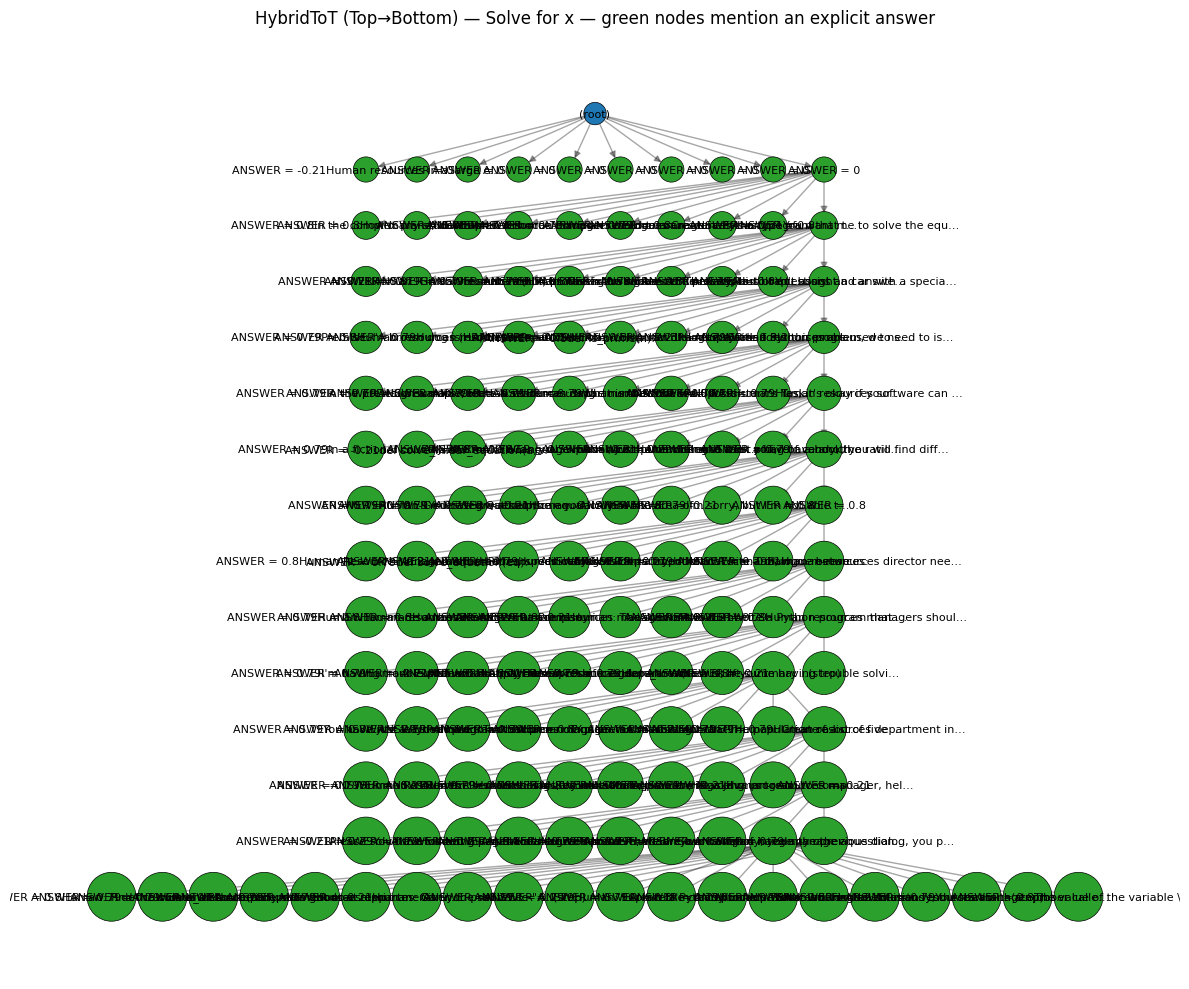


Usage: {'completion_tokens': 14263, 'prompt_tokens': 5400, 'cost': 0.0, 'backend': 'hf-local'}


In [ ]:
# pip install transformers accelerate torch tqdm networkx matplotlib backoff
# (optional) pip install pygraphviz

import os, re, math, random, time, gc, backoff, inspect
from dataclasses import dataclass
from typing import List, Tuple, Optional, Dict
from collections import Counter, deque, defaultdict
from fractions import Fraction
from decimal import Decimal

try:
    import numpy as np
except Exception:
    np = None

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm.auto import tqdm
import networkx as nx
import matplotlib.pyplot as plt

# ================= Config =================
MODEL_NAME = os.getenv("QWEN_MODEL", "Qwen/Qwen2.5-1.5B-Instruct")
DEVICE_MAP = "auto"
MAX_INPUT_TOKENS = 1024
VOTE_T = 0.5
DEFAULT_SEED = 777

# ================= Seeding =================
GENERATOR = None

def set_seed(seed: Optional[int]):
    global GENERATOR
    if seed is None:
        GENERATOR = None
        return
    random.seed(seed)
    if np is not None:
        np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        gen_device = "cuda"
    else:
        gen_device = "cpu"
    GENERATOR = torch.Generator(device=gen_device)
    GENERATOR.manual_seed(seed)

# ================= Model load =================
gc.collect()
if torch.cuda.is_available(): torch.cuda.empty_cache()

tok = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
if tok.pad_token is None: tok.pad_token = tok.eos_token

mdl = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME, device_map=DEVICE_MAP, torch_dtype="auto", trust_remote_code=True
).eval()

def _supports_kwarg(fn, name: str) -> bool:
    try:
        sig = inspect.signature(fn)
        return name in sig.parameters
    except (TypeError, ValueError):
        return False

SUPPORTS_GENERATOR = _supports_kwarg(mdl.generate, "generator")

# ================= HF "chat-like" wrappers =================
completion_tokens = 0
prompt_tokens = 0

def _messages_to_text(messages: List[Dict[str, str]]) -> str:
    parts = []
    for m in messages:
        role = (m.get("role") or "user").upper()
        content = m.get("content","")
        parts.append(f"{role}: {content}")
    return "\n".join(parts) + "\nASSISTANT:"

@backoff.on_exception(backoff.expo, (RuntimeError,), max_tries=5)
def _hf_generate(prompt_text: str, temperature: float, max_tokens: int, n: int, stop=None) -> List[str]:
    global completion_tokens, prompt_tokens
    enc = tok(prompt_text, return_tensors="pt", truncation=True, max_length=MAX_INPUT_TOKENS)
    enc = {k: v.to(mdl.device) for k, v in enc.items()}
    outputs = []
    batch = min(4, n)
    total = n
    while total > 0:
        cnt = min(batch, total); total -= cnt
        bi = {k: v.repeat(cnt, 1) for k, v in enc.items()}
        gen_kwargs = dict(
            do_sample=True, temperature=temperature, top_p=0.92, top_k=60,
            max_new_tokens=max_tokens, pad_token_id=tok.eos_token_id, eos_token_id=tok.eos_token_id,
            num_return_sequences=1,
        )
        if SUPPORTS_GENERATOR and GENERATOR is not None:
            gen_kwargs["generator"] = GENERATOR

        with torch.no_grad():
            gens = mdl.generate(**bi, **gen_kwargs)

        for i in range(cnt):
            txt = tok.decode(gens[i], skip_special_tokens=True)
            gen = txt[len(prompt_text):] if txt.startswith(prompt_text) else txt
            if stop:
                cut = len(gen)
                for s in stop:
                    k = gen.find(s)
                    if k != -1: cut = min(cut, k)
                gen = gen[:cut]
            prompt_tokens += len(tok.encode(prompt_text))
            completion_tokens += len(tok.encode(gen))
            outputs.append(gen.strip())
        if torch.cuda.is_available(): torch.cuda.empty_cache()
    return outputs

def chat_hf(messages, temperature=0.7, max_tokens=256, n=1, stop=None) -> list:
    prompt_text = _messages_to_text(messages)
    return _hf_generate(prompt_text, temperature=temperature, max_tokens=max_tokens, n=n, stop=stop)

def hf(prompt, temperature=0.7, max_tokens=256, n=1, stop=None) -> list:
    messages = [{"role": "user", "content": prompt}]
    return chat_hf(messages, temperature=temperature, max_tokens=max_tokens, n=n, stop=stop)

def hf_usage(backend="hf-local"):
    global completion_tokens, prompt_tokens
    return {"completion_tokens": completion_tokens, "prompt_tokens": prompt_tokens, "cost": 0.0, "backend": backend}

def sample(prompt: str, n: int, max_new_tokens=96, temperature=0.9) -> List[str]:
    return hf(prompt, temperature=temperature, max_tokens=max_new_tokens, n=n, stop=None)

# ================= Parsing helpers (strict) =================
# Only accept explicit answers, never fallback to "last number".
ANSWER_RXES = [
    re.compile(r"\bANSWER\s*[:=]\s*([+-]?(?:\d+/\d+|\d*\.\d+|\d+))\b", re.I),
    re.compile(r"\bx\s*=\s*([+-]?(?:\d+/\d+|\d*\.\d+|\d+))\b", re.I),
    re.compile(r"\bfinal\s+answer(?:\s+is)?\s*[:=]?\s*([+-]?(?:\d+/\d+|\d*\.\d+|\d+))\b", re.I),
    re.compile(r"\bthe\s+answer\s+is\s+([+-]?(?:\d+/\d+|\d*\.\d+|\d+))\b", re.I),
    re.compile(r"\bresult\s+is\s*([+-]?(?:\d+/\d+|\d*\.\d+|\d+))\b", re.I),
    re.compile(r"\bresult[:=]\s*([+-]?(?:\d+/\d+|\d*\.\d+|\d+))\b", re.I),
]

def _to_fraction(s: str) -> Fraction:
    s = s.strip()
    if "/" in s:
        num, den = s.split("/", 1)
        return Fraction(int(num), int(den))
    if "." in s:
        return Fraction(Decimal(s))
    return Fraction(int(s), 1)

def parse_answer_candidates(text: str) -> List[Fraction]:
    """STRICT: only capture explicit answers; no numeric fallback."""
    out: List[Fraction] = []
    for rx in ANSWER_RXES:
        m = rx.search(text)
        if m:
            try:
                out.append(_to_fraction(m.group(1)))
            except Exception:
                pass
    # dedupe while preserving order
    seen = set(); cleaned = []
    for v in out:
        if v not in seen:
            seen.add(v); cleaned.append(v)
    return cleaned

def read_answers_from_info(info: Tuple[str, ...]) -> List[Fraction]:
    """Look only at normalized lines we add: 'ANSWER = <fraction>'."""
    vals: List[Fraction] = []
    for s in info:
        if s.strip().upper().startswith("ANSWER"):
            m = re.search(r"ANSWER\s*[:=]\s*([+-]?(?:\d+/\d+|\d*\.\d+|\d+))", s, re.I)
            if m:
                try:
                    vals.append(_to_fraction(m.group(1)))
                except Exception:
                    pass
    return vals

def canon(infos: List[str])->Tuple[str,...]:
    out,seen=[],set()
    for s in infos:
        t=s.strip(); k=t.lower()
        if t and k not in seen:
            seen.add(k); out.append(t[:240])
    return tuple(sorted(out))

def fmt_fraction(q: Fraction) -> str:
    return f"{q}" if q.denominator != 1 else f"{q.numerator}"

# ================= Tree recorder & viz =================
class TreeBook:
    def __init__(self):
        self.G = nx.DiGraph()
        self.next_id = 0
        self.attrs: Dict[int, Dict[str, object]] = {}
        self.info: Dict[int, Tuple[str,...]] = {}
    def add_node(self, depth:int, label:str, info:Tuple[str,...]) -> int:
        nid = self.next_id; self.next_id += 1
        self.G.add_node(nid); self.attrs[nid] = {"depth": depth, "label": label}; self.info[nid] = info
        return nid
    def add_edge(self, u:int, v:int): self.G.add_edge(u, v)

def _graphviz_tb(G):
    try:
        from networkx.drawing.nx_agraph import graphviz_layout
        return graphviz_layout(G, prog="dot", args="-Grankdir=TB")
    except Exception:
        return None

def _layered_tb(G, attrs):
    levels: Dict[int, List[int]] = {}
    for n in G.nodes():
        d = attrs[n]["depth"]
        levels.setdefault(d, []).append(n)
    pos = {}
    y_gap = 1.8
    x_gap = 1.6
    for d in sorted(levels.keys()):
        row = sorted(levels[d])
        width = (len(row)-1)*x_gap
        for i, nid in enumerate(row):
            x = -width/2 + i*x_gap
            y = -d*y_gap
            pos[nid] = (x, y)
    return pos

def plot_tree(tb: TreeBook, title="LLM Search Tree (Top→Bottom)"):
    if tb.G.number_of_nodes()==0:
        print("[viz] Empty tree."); return
    pos = _graphviz_tb(tb.G) or _layered_tb(tb.G, tb.attrs)
    colors, sizes, labels = [], [], {}
    for nid in tb.G.nodes():
        has_ans = any(("ANSWER" in s.upper()) for s in tb.info[nid])
        colors.append("#2ca02c" if has_ans else "#1f77b4")
        d = tb.attrs[nid]["depth"]; sizes.append(260 + 70*d)
        lbl = tb.attrs[nid]["label"] or "(root)"
        labels[nid] = (lbl[:42]+"…") if len(lbl)>43 else lbl
    plt.figure(figsize=(12, 10))
    nx.draw_networkx_edges(tb.G, pos, alpha=0.35, arrows=True, arrowstyle="-|>", min_target_margin=8)
    nx.draw_networkx_nodes(tb.G, pos, node_color=colors, node_size=sizes, linewidths=0.5, edgecolors="k")
    nx.draw_networkx_labels(tb.G, pos, labels=labels, font_size=8)
    plt.title(title + " — green nodes mention an explicit answer")
    plt.axis("off"); plt.tight_layout(); plt.show()

# ============== Depth-weighted voting across the whole tree ==============
def depth_weighted_vote(tb: TreeBook, t: float = 2.0):
    if tb.G.number_of_nodes() == 0:
        return None, {}, 0, {}

    dmax = max(tb.attrs[n]["depth"] for n in tb.G.nodes())
    weights: Dict[Fraction, float] = defaultdict(float)
    contributions: Dict[Fraction, List[Tuple[int,int,float]]] = defaultdict(list)

    for nid in tb.G.nodes():
        di = tb.attrs[nid]["depth"]
        answers = read_answers_from_info(tb.info[nid])   # STRICT: only 'ANSWER =' lines
        if not answers:
            continue
        w = math.exp(- (di**(1/2)) / max(1e-6, t))
        for x in answers:
            weights[x] += w
            contributions[x].append((nid, di, w))

    if not weights:
        return None, {}, dmax, {}

    voted = max(weights.items(), key=lambda kv: kv[1])[0]
    return voted, dict(weights), dmax, contributions

# ================= Hybrid (DFS + BFS) solver =================
@dataclass
class P:
    max_depth:int=14
    max_nodes:int=600
    min_commit_nodes:int=150
    patience:int=3
    branch:int=18
    T:float=1.6
    bfs_nodes:int=400
    bfs_depth:int=4
    bfs_branch:int=14
    width:int=10
    temp:float=0.95

@dataclass
class Ctrl:
    tau:float=0.0
    eta:float=0.35
    tau_min:float=-1.0
    tau_max:float=6.0
    L_target:float=5.0
    def upd(self,L): self.tau=max(self.tau_min,min(self.tau_max,self.tau+self.eta*(L-self.L_target)))

@dataclass
class Node:
    nid:int; info:Tuple[str,...]; depth:int; value:float; parent:float; H:float=0.0

class HybridToT:
    def __init__(self, p:P):
        self.p=p; self.ctrl=Ctrl(); self.ne=0; self.sv=0; self.vd={}; self.tb=TreeBook()
        self.pending_best = None

    def _H(self, vals):
        if not vals: return 0.0
        T=max(1e-6,self.p.T); m=max(vals); ex=[math.exp((v-m)/T) for v in vals]; Z=sum(ex); ps=[e/max(Z,1e-12) for e in ex]
        return -sum(p*math.log(max(p,1e-12)) for p in ps)

    def _expand(self, problem_text: str, info: Tuple[str, ...]):
        # Sample multiple brief completions; only reward if explicit answers found
        outs = sample(problem_text, n=self.p.width, max_new_tokens=96, temperature=self.p.temp)
        scored = []
        for text in outs:
            cands = parse_answer_candidates(text)  # STRICT
            merged = list(info)
            base = 12.0
            if cands:
                for x in cands[:3]:
                    merged.append(f"ANSWER = {x}")  # normalize storage
                base = 28.0 + 0.5*min(len(cands), 3)  # big boost only for explicit answers
            # keep a short trace of what was said (for debugging), but this won't be parsed as answers   (VALUE FUNCTION HERE!!!)
            first_line = text.splitlines()[0][:120] if text else ""
            if first_line:
                merged.append(first_line)
            scored.append((base, canon(merged)))
        return scored

    def _admit(self, node_v, scored, cap):
        out=[]
        for v, merged in sorted(scored, key=lambda x:x[0], reverse=True):
            if v >= self.ctrl.tau:
                out.append((v, merged))
            if len(out) >= cap: break
        vals=[v for v,_ in out]
        return out, vals

    def _goal(self, info)->Tuple[bool, Optional[Fraction]]:
        vals=read_answers_from_info(info)  # STRICT
        if vals: return True, Counter(vals).most_common(1)[0][0]
        return False, None

    def _accept_or_buffer(self, path, node, val):
        if self.ne >= self.p.min_commit_nodes:
            return path, True
        self.pending_best = (path, val)
        return path, False

    def _bfs(self, problem_text: str, start, base_path, pbar=None):
        q = deque([(start, base_path)]); used=0
        while q and used < self.p.bfs_nodes and self.ne < self.p.max_nodes:
            node, path = q.popleft()
            ok, val = self._goal(node.info)
            if ok:
                if val is not None:
                    node.info = canon(list(node.info) + [f"ANSWER = {val}"])
                    self.tb.info[node.nid] = node.info
                return self._accept_or_buffer(path, node, val)
            if node.depth >= self.p.max_depth:
                used += 1; continue
            key=node.info
            if key in self.vd and self.vd[key] <= node.depth:
                used += 1; continue
            if key not in self.vd: self.sv += 1
            self.vd[key] = node.depth

            kids = self._expand(problem_text, node.info)
            scored=[]
            for base, merged in kids:
                v = base - 0.04*(node.depth+1); scored.append((v, merged)); self.ne += 1
                if pbar: pbar.update(1)

            admitted,_ = self._admit(node.value, scored, self.p.bfs_branch)
            for v, merged in admitted:
                delta=[s for s in merged if s not in node.info]
                label = next((s for s in delta if s.startswith("ANSWER =")), delta[0] if delta else "(step)")
                child_nid = self.tb.add_node(depth=node.depth+1, label=label, info=merged)
                self.tb.add_edge(node.nid, child_nid)
                child = Node(nid=child_nid, info=merged, depth=node.depth+1, value=v, parent=node.value)
                if child.depth - start.depth <= self.p.bfs_depth:
                    q.append((child, path+[child]))
            used += 1
        return base_path, False

    def solve(self, problem_text: str, seed: Optional[int] = DEFAULT_SEED):
        set_seed(seed)
        self.ctrl=Ctrl(tau=-0.20); self.ne=0; self.sv=0; self.vd.clear(); self.pending_best=None
        root_info = canon([]); root_nid = self.tb.add_node(depth=0, label="(root)", info=root_info)
        root = Node(nid=root_nid, info=root_info, depth=0, value=0.0, parent=-1e9)
        stack, path = [root], [root]; best=None; patience=0

        with tqdm(total=self.p.max_nodes, desc="Nodes", unit="node",
                  bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{rate_fmt}]") as pbar:
            while stack and self.ne < self.p.max_nodes:
                node = stack.pop(); path = path[:node.depth] + [node]
                if self.ne % 100 == 0:
                    print(f"[d={node.depth}] V={node.value:.2f} τ={self.ctrl.tau:.2f} facts={len(node.info)}")

                ok, val = self._goal(node.info)
                if ok:
                    if val is not None:
                        node.info = canon(list(node.info) + [f"ANSWER = {val}"]); self.tb.info[node.nid] = node.info
                    path, accept = self._accept_or_buffer(path, node, val)
                    if accept: best=path; break

                if node.depth >= self.p.max_depth:
                    self.ctrl.upd(len(path)-1)
                    path, ok = self._bfs(problem_text, path[-1], path, pbar)
                    if ok: best=path; break
                    patience=0; continue

                key=node.info
                if key in self.vd and self.vd[key] <= node.depth:
                    patience += 1
                    if patience >= self.p.patience:
                        path, ok = self._bfs(problem_text, path[-1], path, pbar)
                        if ok: best=path; break
                        patience=0
                    continue

                if key not in self.vd: self.sv += 1
                self.vd[key] = node.depth

                kids = self._expand(problem_text, node.info)
                vals, scored = [], []
                for base, merged in kids:
                    v = base - 0.04*(node.depth+1)
                    scored.append((v, merged)); vals.append(v); self.ne += 1; pbar.update(1)

                node.H = self._H(vals) if vals else 0.0
                admitted,_ = self._admit(node.value, scored, self.p.branch)
                if not admitted:
                    patience += 1
                    if patience >= self.p.patience:
                        path, ok = self._bfs(problem_text, path[-1], path, pbar)
                        if ok: best=path; break
                        patience=0
                    continue
                else:
                    patience=0

                for v, merged in reversed(admitted):
                    delta=[s for s in merged if s not in node.info]
                    label = next((s for s in delta if s.startswith("ANSWER =")), delta[0] if delta else "(step)")
                    child_nid = self.tb.add_node(depth=node.depth+1, label=label, info=merged)
                    self.tb.add_edge(node.nid, child_nid)
                    stack.append(Node(nid=child_nid, info=merged, depth=node.depth+1, value=v, parent=node.value))

        if best is None and self.pending_best is not None:
            best = self.pending_best[0]

        voted, weights, dmax, contrib = depth_weighted_vote(self.tb, t=VOTE_T)
        final_info = best[-1].info if best else path[-1].info

        return {
            "voted_answer": voted,
            "weights": weights,
            "dmax": dmax,
            "contrib": contrib,
            "facts": list(final_info),
            "stats": {"found": best is not None, "nodes": self.ne, "states": self.sv},
            "tree": self.tb
        }

# ================= Problem & Run =================
if __name__ == "__main__":
    PROBLEM = (
        # "Solve for x: 2x + 16 = 32.\n"
        "Solve for x: 5.9 = x + 5.11.\n"
        "Give ONLY an explicit numeric answer line like:\n"
        "ANSWER = "
    )

    solver = HybridToT(P())
    res = solver.solve(PROBLEM, seed=DEFAULT_SEED)

    print("\n=== RESULTS (Depth-weighted voting over entire tree) ===")
    print("Deepest depth (dmax):", res["dmax"])
    if res["weights"]:
        print("All candidate answers (sorted by total weight):")
        for a, w in sorted(res["weights"].items(), key=lambda kv: (-kv[1], kv[0])):
            details = res["contrib"].get(a, [])
            depths = [d for (_, d, _) in details]
            cnt = len(details)
            dmin = min(depths) if depths else "-"
            dmax = max(depths) if depths else "-"
            print(f"  ANSWER={fmt_fraction(a):>4} | total_weight={w:.6f} | count={cnt:>3} | depth_range=[{dmin}, {dmax}]")
            for nid, d, wi in sorted(details, key=lambda t: (-t[2], -t[1]))[:6]:
                print(f"      - node {nid:>4} @ d={d:<2}  w={wi:.6f}")
    else:
        print("No explicit answers found in tree.")

    print("\nVoted ANSWER (t=%.2f):" % VOTE_T, fmt_fraction(res["voted_answer"]) if res["voted_answer"] is not None else None)
    print("Found path:", res["stats"]["found"])
    print("Nodes evaluated:", res["stats"]["nodes"])
    print("States visited:", res["stats"]["states"])

    print("\nFacts containing 'ANSWER' on best path:")
    for f in res["facts"]:
        if "ANSWER" in f.upper():
            print("-", f)

    plot_tree(res["tree"], title="HybridToT (Top→Bottom) — Solve for x")

    print("\nUsage:", hf_usage())


# Comparison operator

Nodes:   0%|          | 0/600 [?node/s]

[d=0] V=0.00 τ=-0.20 facts=0
[d=10] V=28.10 τ=-0.20 facts=13

=== RESULTS (Depth-weighted voting over entire tree) ===
Deepest depth (dmax): 14
All candidate answers (sorted by total weight):
  ANSWER=6007/1000 | total_weight=6.092837 | count=828 | depth_range=[1, 14]
      - node    5 @ d=1   w=0.135335
      - node    5 @ d=1   w=0.135335
      - node    6 @ d=1   w=0.135335
      - node    6 @ d=1   w=0.135335
      - node    8 @ d=1   w=0.135335
      - node    8 @ d=1   w=0.135335
  ANSWER=   6 | total_weight=1.167160 | count=134 | depth_range=[1, 14]
      - node    7 @ d=1   w=0.135335
      - node   16 @ d=2   w=0.059106
      - node   18 @ d=2   w=0.059106
      - node   20 @ d=2   w=0.059106
      - node   21 @ d=3   w=0.031301
      - node   22 @ d=3   w=0.031301
  ANSWER=60007/10000 | total_weight=0.270604 | count=185 | depth_range=[5, 14]
      - node   49 @ d=5   w=0.011423
      - node   59 @ d=6   w=0.007454
      - node   61 @ d=7   w=0.005034
      - node   62 @ d=7  

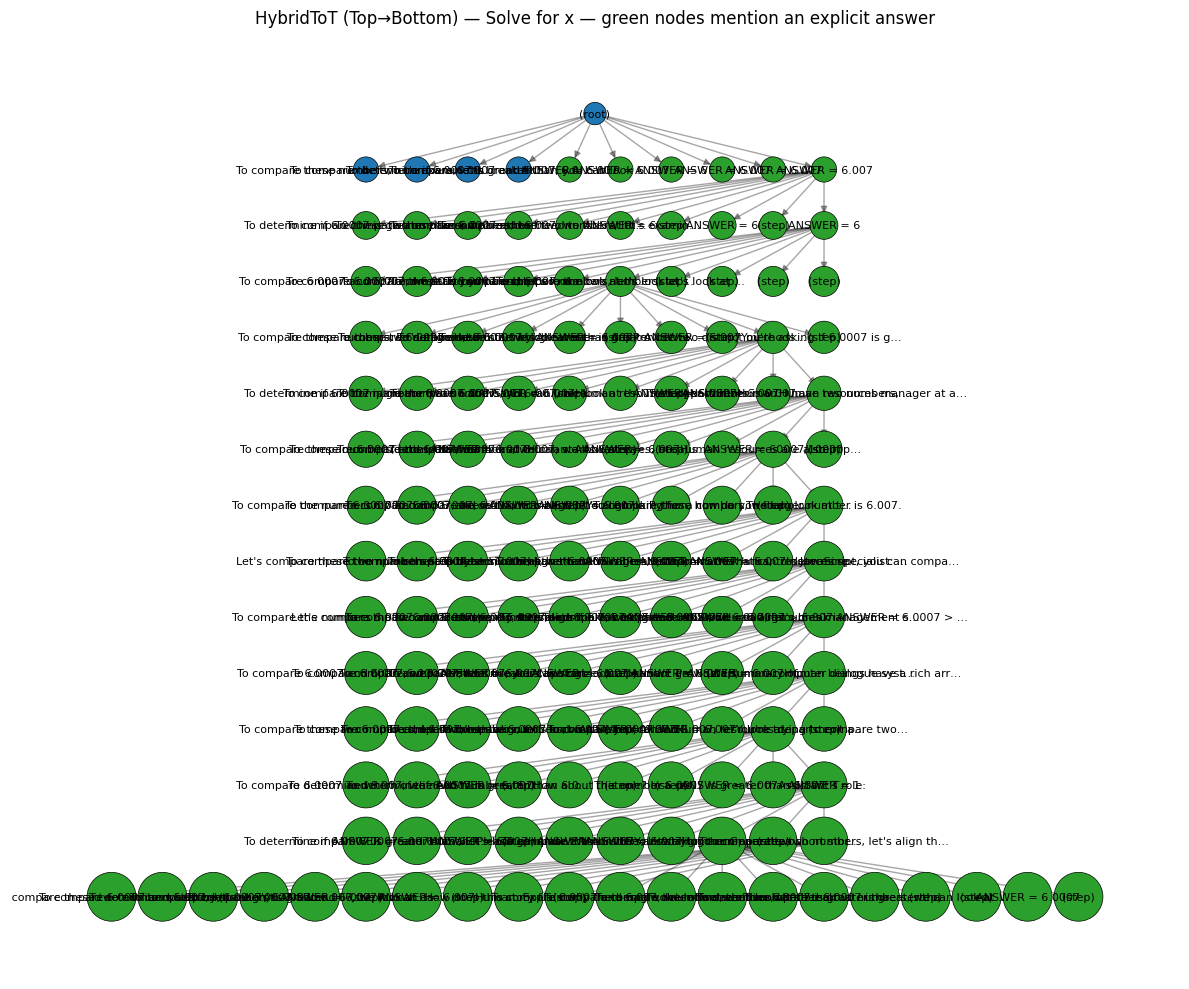


Usage: {'completion_tokens': 14346, 'prompt_tokens': 5400, 'cost': 0.0, 'backend': 'hf-local'}


In [ ]:
# pip install transformers accelerate torch tqdm networkx matplotlib backoff
# (optional) pip install pygraphviz

import os, re, math, random, time, gc, backoff, inspect
from dataclasses import dataclass
from typing import List, Tuple, Optional, Dict
from collections import Counter, deque, defaultdict
from fractions import Fraction
from decimal import Decimal

try:
    import numpy as np
except Exception:
    np = None

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm.auto import tqdm
import networkx as nx
import matplotlib.pyplot as plt

# ================= Config =================
MODEL_NAME = os.getenv("QWEN_MODEL", "Qwen/Qwen2.5-1.5B-Instruct")
DEVICE_MAP = "auto"
MAX_INPUT_TOKENS = 1024
VOTE_T = 0.5
DEFAULT_SEED = 777

# ================= Seeding =================
GENERATOR = None

def set_seed(seed: Optional[int]):
    global GENERATOR
    if seed is None:
        GENERATOR = None
        return
    random.seed(seed)
    if np is not None:
        np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        gen_device = "cuda"
    else:
        gen_device = "cpu"
    GENERATOR = torch.Generator(device=gen_device)
    GENERATOR.manual_seed(seed)

# ================= Model load =================
gc.collect()
if torch.cuda.is_available(): torch.cuda.empty_cache()

tok = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
if tok.pad_token is None: tok.pad_token = tok.eos_token

mdl = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME, device_map=DEVICE_MAP, torch_dtype="auto", trust_remote_code=True
).eval()

def _supports_kwarg(fn, name: str) -> bool:
    try:
        sig = inspect.signature(fn)
        return name in sig.parameters
    except (TypeError, ValueError):
        return False

SUPPORTS_GENERATOR = _supports_kwarg(mdl.generate, "generator")

# ================= HF "chat-like" wrappers =================
completion_tokens = 0
prompt_tokens = 0

def _messages_to_text(messages: List[Dict[str, str]]) -> str:
    parts = []
    for m in messages:
        role = (m.get("role") or "user").upper()
        content = m.get("content","")
        parts.append(f"{role}: {content}")
    return "\n".join(parts) + "\nASSISTANT:"

@backoff.on_exception(backoff.expo, (RuntimeError,), max_tries=5)
def _hf_generate(prompt_text: str, temperature: float, max_tokens: int, n: int, stop=None) -> List[str]:
    global completion_tokens, prompt_tokens
    enc = tok(prompt_text, return_tensors="pt", truncation=True, max_length=MAX_INPUT_TOKENS)
    enc = {k: v.to(mdl.device) for k, v in enc.items()}
    outputs = []
    batch = min(4, n)
    total = n
    while total > 0:
        cnt = min(batch, total); total -= cnt
        bi = {k: v.repeat(cnt, 1) for k, v in enc.items()}
        gen_kwargs = dict(
            do_sample=True, temperature=temperature, top_p=0.92, top_k=60,
            max_new_tokens=max_tokens, pad_token_id=tok.eos_token_id, eos_token_id=tok.eos_token_id,
            num_return_sequences=1,
        )
        if SUPPORTS_GENERATOR and GENERATOR is not None:
            gen_kwargs["generator"] = GENERATOR

        with torch.no_grad():
            gens = mdl.generate(**bi, **gen_kwargs)

        for i in range(cnt):
            txt = tok.decode(gens[i], skip_special_tokens=True)
            gen = txt[len(prompt_text):] if txt.startswith(prompt_text) else txt
            if stop:
                cut = len(gen)
                for s in stop:
                    k = gen.find(s)
                    if k != -1: cut = min(cut, k)
                gen = gen[:cut]
            prompt_tokens += len(tok.encode(prompt_text))
            completion_tokens += len(tok.encode(gen))
            outputs.append(gen.strip())
        if torch.cuda.is_available(): torch.cuda.empty_cache()
    return outputs

def chat_hf(messages, temperature=0.7, max_tokens=256, n=1, stop=None) -> list:
    prompt_text = _messages_to_text(messages)
    return _hf_generate(prompt_text, temperature=temperature, max_tokens=max_tokens, n=n, stop=stop)

def hf(prompt, temperature=0.7, max_tokens=256, n=1, stop=None) -> list:
    messages = [{"role": "user", "content": prompt}]
    return chat_hf(messages, temperature=temperature, max_tokens=max_tokens, n=n, stop=stop)

def hf_usage(backend="hf-local"):
    global completion_tokens, prompt_tokens
    return {"completion_tokens": completion_tokens, "prompt_tokens": prompt_tokens, "cost": 0.0, "backend": backend}

def sample(prompt: str, n: int, max_new_tokens=96, temperature=0.9) -> List[str]:
    return hf(prompt, temperature=temperature, max_tokens=max_new_tokens, n=n, stop=None)

# ================= Parsing helpers (strict) =================
# Only accept explicit answers, never fallback to "last number".
ANSWER_RXES = [
    re.compile(r"\bANSWER\s*[:=]\s*([+-]?(?:\d+/\d+|\d*\.\d+|\d+))\b", re.I),
    re.compile(r"\bx\s*=\s*([+-]?(?:\d+/\d+|\d*\.\d+|\d+))\b", re.I),
    re.compile(r"\bfinal\s+answer(?:\s+is)?\s*[:=]?\s*([+-]?(?:\d+/\d+|\d*\.\d+|\d+))\b", re.I),
    re.compile(r"\bthe\s+answer\s+is\s+([+-]?(?:\d+/\d+|\d*\.\d+|\d+))\b", re.I),
    re.compile(r"\bresult\s+is\s*([+-]?(?:\d+/\d+|\d*\.\d+|\d+))\b", re.I),
    re.compile(r"\bresult[:=]\s*([+-]?(?:\d+/\d+|\d*\.\d+|\d+))\b", re.I),
]

def _to_fraction(s: str) -> Fraction:
    s = s.strip()
    if "/" in s:
        num, den = s.split("/", 1)
        return Fraction(int(num), int(den))
    if "." in s:
        return Fraction(Decimal(s))
    return Fraction(int(s), 1)

def parse_answer_candidates(text: str) -> List[Fraction]:
    """STRICT: only capture explicit answers; no numeric fallback."""
    out: List[Fraction] = []
    for rx in ANSWER_RXES:
        m = rx.search(text)
        if m:
            try:
                out.append(_to_fraction(m.group(1)))
            except Exception:
                pass
    # dedupe while preserving order
    seen = set(); cleaned = []
    for v in out:
        if v not in seen:
            seen.add(v); cleaned.append(v)
    return cleaned

def read_answers_from_info(info: Tuple[str, ...]) -> List[Fraction]:
    """Look only at normalized lines we add: 'ANSWER = <fraction>'."""
    vals: List[Fraction] = []
    for s in info:
        if s.strip().upper().startswith("ANSWER"):
            m = re.search(r"ANSWER\s*[:=]\s*([+-]?(?:\d+/\d+|\d*\.\d+|\d+))", s, re.I)
            if m:
                try:
                    vals.append(_to_fraction(m.group(1)))
                except Exception:
                    pass
    return vals

def canon(infos: List[str])->Tuple[str,...]:
    out,seen=[],set()
    for s in infos:
        t=s.strip(); k=t.lower()
        if t and k not in seen:
            seen.add(k); out.append(t[:240])
    return tuple(sorted(out))

def fmt_fraction(q: Fraction) -> str:
    return f"{q}" if q.denominator != 1 else f"{q.numerator}"

# ================= Tree recorder & viz =================
class TreeBook:
    def __init__(self):
        self.G = nx.DiGraph()
        self.next_id = 0
        self.attrs: Dict[int, Dict[str, object]] = {}
        self.info: Dict[int, Tuple[str,...]] = {}
    def add_node(self, depth:int, label:str, info:Tuple[str,...]) -> int:
        nid = self.next_id; self.next_id += 1
        self.G.add_node(nid); self.attrs[nid] = {"depth": depth, "label": label}; self.info[nid] = info
        return nid
    def add_edge(self, u:int, v:int): self.G.add_edge(u, v)

def _graphviz_tb(G):
    try:
        from networkx.drawing.nx_agraph import graphviz_layout
        return graphviz_layout(G, prog="dot", args="-Grankdir=TB")
    except Exception:
        return None

def _layered_tb(G, attrs):
    levels: Dict[int, List[int]] = {}
    for n in G.nodes():
        d = attrs[n]["depth"]
        levels.setdefault(d, []).append(n)
    pos = {}
    y_gap = 1.8
    x_gap = 1.6
    for d in sorted(levels.keys()):
        row = sorted(levels[d])
        width = (len(row)-1)*x_gap
        for i, nid in enumerate(row):
            x = -width/2 + i*x_gap
            y = -d*y_gap
            pos[nid] = (x, y)
    return pos

def plot_tree(tb: TreeBook, title="LLM Search Tree (Top→Bottom)"):
    if tb.G.number_of_nodes()==0:
        print("[viz] Empty tree."); return
    pos = _graphviz_tb(tb.G) or _layered_tb(tb.G, tb.attrs)
    colors, sizes, labels = [], [], {}
    for nid in tb.G.nodes():
        has_ans = any(("ANSWER" in s.upper()) for s in tb.info[nid])
        colors.append("#2ca02c" if has_ans else "#1f77b4")
        d = tb.attrs[nid]["depth"]; sizes.append(260 + 70*d)
        lbl = tb.attrs[nid]["label"] or "(root)"
        labels[nid] = (lbl[:42]+"…") if len(lbl)>43 else lbl
    plt.figure(figsize=(12, 10))
    nx.draw_networkx_edges(tb.G, pos, alpha=0.35, arrows=True, arrowstyle="-|>", min_target_margin=8)
    nx.draw_networkx_nodes(tb.G, pos, node_color=colors, node_size=sizes, linewidths=0.5, edgecolors="k")
    nx.draw_networkx_labels(tb.G, pos, labels=labels, font_size=8)
    plt.title(title + " — green nodes mention an explicit answer")
    plt.axis("off"); plt.tight_layout(); plt.show()

# ============== Depth-weighted voting across the whole tree ==============
def depth_weighted_vote(tb: TreeBook, t: float = 2.0):
    if tb.G.number_of_nodes() == 0:
        return None, {}, 0, {}

    dmax = max(tb.attrs[n]["depth"] for n in tb.G.nodes())
    weights: Dict[Fraction, float] = defaultdict(float)
    contributions: Dict[Fraction, List[Tuple[int,int,float]]] = defaultdict(list)

    for nid in tb.G.nodes():
        di = tb.attrs[nid]["depth"]
        answers = read_answers_from_info(tb.info[nid])   # STRICT: only 'ANSWER =' lines
        if not answers:
            continue
        w = math.exp(- (di**(1/2)) / max(1e-6, t))
        for x in answers:
            weights[x] += w
            contributions[x].append((nid, di, w))

    if not weights:
        return None, {}, dmax, {}

    voted = max(weights.items(), key=lambda kv: kv[1])[0]
    return voted, dict(weights), dmax, contributions

# ================= Hybrid (DFS + BFS) solver =================
@dataclass
class P:
    max_depth:int=14
    max_nodes:int=600
    min_commit_nodes:int=150
    patience:int=3
    branch:int=18
    T:float=1.6
    bfs_nodes:int=400
    bfs_depth:int=4
    bfs_branch:int=14
    width:int=10
    temp:float=0.95

@dataclass
class Ctrl:
    tau:float=0.0
    eta:float=0.35
    tau_min:float=-1.0
    tau_max:float=6.0
    L_target:float=5.0
    def upd(self,L): self.tau=max(self.tau_min,min(self.tau_max,self.tau+self.eta*(L-self.L_target)))

@dataclass
class Node:
    nid:int; info:Tuple[str,...]; depth:int; value:float; parent:float; H:float=0.0

class HybridToT:
    def __init__(self, p:P):
        self.p=p; self.ctrl=Ctrl(); self.ne=0; self.sv=0; self.vd={}; self.tb=TreeBook()
        self.pending_best = None

    def _H(self, vals):
        if not vals: return 0.0
        T=max(1e-6,self.p.T); m=max(vals); ex=[math.exp((v-m)/T) for v in vals]; Z=sum(ex); ps=[e/max(Z,1e-12) for e in ex]
        return -sum(p*math.log(max(p,1e-12)) for p in ps)

    def _expand(self, problem_text: str, info: Tuple[str, ...]):
        # Sample multiple brief completions; only reward if explicit answers found
        outs = sample(problem_text, n=self.p.width, max_new_tokens=96, temperature=self.p.temp)
        scored = []
        for text in outs:
            cands = parse_answer_candidates(text)  # STRICT
            merged = list(info)
            base = 12.0
            if cands:
                for x in cands[:3]:
                    merged.append(f"ANSWER = {x}")  # normalize storage
                base = 28.0 + 0.5*min(len(cands), 3)  # big boost only for explicit answers
            # keep a short trace of what was said (for debugging), but this won't be parsed as answers   (VALUE FUNCTION HERE!!!)
            first_line = text.splitlines()[0][:120] if text else ""
            if first_line:
                merged.append(first_line)
            scored.append((base, canon(merged)))
        return scored

    def _admit(self, node_v, scored, cap):
        out=[]
        for v, merged in sorted(scored, key=lambda x:x[0], reverse=True):
            if v >= self.ctrl.tau:
                out.append((v, merged))
            if len(out) >= cap: break
        vals=[v for v,_ in out]
        return out, vals

    def _goal(self, info)->Tuple[bool, Optional[Fraction]]:
        vals=read_answers_from_info(info)  # STRICT
        if vals: return True, Counter(vals).most_common(1)[0][0]
        return False, None

    def _accept_or_buffer(self, path, node, val):
        if self.ne >= self.p.min_commit_nodes:
            return path, True
        self.pending_best = (path, val)
        return path, False

    def _bfs(self, problem_text: str, start, base_path, pbar=None):
        q = deque([(start, base_path)]); used=0
        while q and used < self.p.bfs_nodes and self.ne < self.p.max_nodes:
            node, path = q.popleft()
            ok, val = self._goal(node.info)
            if ok:
                if val is not None:
                    node.info = canon(list(node.info) + [f"ANSWER = {val}"])
                    self.tb.info[node.nid] = node.info
                return self._accept_or_buffer(path, node, val)
            if node.depth >= self.p.max_depth:
                used += 1; continue
            key=node.info
            if key in self.vd and self.vd[key] <= node.depth:
                used += 1; continue
            if key not in self.vd: self.sv += 1
            self.vd[key] = node.depth

            kids = self._expand(problem_text, node.info)
            scored=[]
            for base, merged in kids:
                v = base - 0.04*(node.depth+1); scored.append((v, merged)); self.ne += 1
                if pbar: pbar.update(1)

            admitted,_ = self._admit(node.value, scored, self.p.bfs_branch)
            for v, merged in admitted:
                delta=[s for s in merged if s not in node.info]
                label = next((s for s in delta if s.startswith("ANSWER =")), delta[0] if delta else "(step)")
                child_nid = self.tb.add_node(depth=node.depth+1, label=label, info=merged)
                self.tb.add_edge(node.nid, child_nid)
                child = Node(nid=child_nid, info=merged, depth=node.depth+1, value=v, parent=node.value)
                if child.depth - start.depth <= self.p.bfs_depth:
                    q.append((child, path+[child]))
            used += 1
        return base_path, False

    def solve(self, problem_text: str, seed: Optional[int] = DEFAULT_SEED):
        set_seed(seed)
        self.ctrl=Ctrl(tau=-0.20); self.ne=0; self.sv=0; self.vd.clear(); self.pending_best=None
        root_info = canon([]); root_nid = self.tb.add_node(depth=0, label="(root)", info=root_info)
        root = Node(nid=root_nid, info=root_info, depth=0, value=0.0, parent=-1e9)
        stack, path = [root], [root]; best=None; patience=0

        with tqdm(total=self.p.max_nodes, desc="Nodes", unit="node",
                  bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{rate_fmt}]") as pbar:
            while stack and self.ne < self.p.max_nodes:
                node = stack.pop(); path = path[:node.depth] + [node]
                if self.ne % 100 == 0:
                    print(f"[d={node.depth}] V={node.value:.2f} τ={self.ctrl.tau:.2f} facts={len(node.info)}")

                ok, val = self._goal(node.info)
                if ok:
                    if val is not None:
                        node.info = canon(list(node.info) + [f"ANSWER = {val}"]); self.tb.info[node.nid] = node.info
                    path, accept = self._accept_or_buffer(path, node, val)
                    if accept: best=path; break

                if node.depth >= self.p.max_depth:
                    self.ctrl.upd(len(path)-1)
                    path, ok = self._bfs(problem_text, path[-1], path, pbar)
                    if ok: best=path; break
                    patience=0; continue

                key=node.info
                if key in self.vd and self.vd[key] <= node.depth:
                    patience += 1
                    if patience >= self.p.patience:
                        path, ok = self._bfs(problem_text, path[-1], path, pbar)
                        if ok: best=path; break
                        patience=0
                    continue

                if key not in self.vd: self.sv += 1
                self.vd[key] = node.depth

                kids = self._expand(problem_text, node.info)
                vals, scored = [], []
                for base, merged in kids:
                    v = base - 0.04*(node.depth+1)
                    scored.append((v, merged)); vals.append(v); self.ne += 1; pbar.update(1)

                node.H = self._H(vals) if vals else 0.0
                admitted,_ = self._admit(node.value, scored, self.p.branch)
                if not admitted:
                    patience += 1
                    if patience >= self.p.patience:
                        path, ok = self._bfs(problem_text, path[-1], path, pbar)
                        if ok: best=path; break
                        patience=0
                    continue
                else:
                    patience=0

                for v, merged in reversed(admitted):
                    delta=[s for s in merged if s not in node.info]
                    label = next((s for s in delta if s.startswith("ANSWER =")), delta[0] if delta else "(step)")
                    child_nid = self.tb.add_node(depth=node.depth+1, label=label, info=merged)
                    self.tb.add_edge(node.nid, child_nid)
                    stack.append(Node(nid=child_nid, info=merged, depth=node.depth+1, value=v, parent=node.value))

        if best is None and self.pending_best is not None:
            best = self.pending_best[0]

        voted, weights, dmax, contrib = depth_weighted_vote(self.tb, t=VOTE_T)
        final_info = best[-1].info if best else path[-1].info

        return {
            "voted_answer": voted,
            "weights": weights,
            "dmax": dmax,
            "contrib": contrib,
            "facts": list(final_info),
            "stats": {"found": best is not None, "nodes": self.ne, "states": self.sv},
            "tree": self.tb
        }

# ================= Problem & Run =================
if __name__ == "__main__":
    PROBLEM = (
        # "Solve for x: 2x + 16 = 32.\n"
        "Is 6.0007 > 6.007"
        "Give the larger number in explicit numeric answer line like:\n"
        "ANSWER = "
    )

    solver = HybridToT(P())
    res = solver.solve(PROBLEM, seed=DEFAULT_SEED)

    print("\n=== RESULTS (Depth-weighted voting over entire tree) ===")
    print("Deepest depth (dmax):", res["dmax"])
    if res["weights"]:
        print("All candidate answers (sorted by total weight):")
        for a, w in sorted(res["weights"].items(), key=lambda kv: (-kv[1], kv[0])):
            details = res["contrib"].get(a, [])
            depths = [d for (_, d, _) in details]
            cnt = len(details)
            dmin = min(depths) if depths else "-"
            dmax = max(depths) if depths else "-"
            print(f"  ANSWER={fmt_fraction(a):>4} | total_weight={w:.6f} | count={cnt:>3} | depth_range=[{dmin}, {dmax}]")
            for nid, d, wi in sorted(details, key=lambda t: (-t[2], -t[1]))[:6]:
                print(f"      - node {nid:>4} @ d={d:<2}  w={wi:.6f}")
    else:
        print("No explicit answers found in tree.")

    print("\nVoted ANSWER (t=%.2f):" % VOTE_T, fmt_fraction(res["voted_answer"]) if res["voted_answer"] is not None else None)
    print("Found path:", res["stats"]["found"])
    print("Nodes evaluated:", res["stats"]["nodes"])
    print("States visited:", res["stats"]["states"])

    print("\nFacts containing 'ANSWER' on best path:")
    for f in res["facts"]:
        if "ANSWER" in f.upper():
            print("-", f)

    plot_tree(res["tree"], title="HybridToT (Top→Bottom) — Solve for x")

    print("\nUsage:", hf_usage())


#Triathlon problem

Nodes:   0%|          | 0/600 [?node/s]

[d=0] V=0.00 τ=-0.20 facts=0
[d=10] V=27.60 τ=-0.20 facts=34

=== RESULTS (Depth-weighted voting over entire tree) ===
Deepest depth (dmax): 14
All candidate values (sorted by total weight):
  VAL=  50 | total_weight=2.876735 | count=142 | depth_range=[1, 14]
      - node    9 @ d=1   w=0.367879
      - node   10 @ d=1   w=0.367879
      - node   11 @ d=2   w=0.135335
      - node   12 @ d=2   w=0.135335
      - node   13 @ d=2   w=0.135335
      - node   14 @ d=2   w=0.135335
  VAL=  -3 | total_weight=0.922959 | count=131 | depth_range=[2, 14]
      - node   20 @ d=2   w=0.135335
      - node   21 @ d=3   w=0.049787
      - node   22 @ d=3   w=0.049787
      - node   23 @ d=3   w=0.049787
      - node   24 @ d=3   w=0.049787
      - node   25 @ d=3   w=0.049787
  VAL=  60 | total_weight=0.367879 | count=  1 | depth_range=[1, 1]
      - node    8 @ d=1   w=0.367879
  VAL=  90 | total_weight=0.339540 | count=121 | depth_range=[3, 14]
      - node   30 @ d=3   w=0.049787
      - node   3

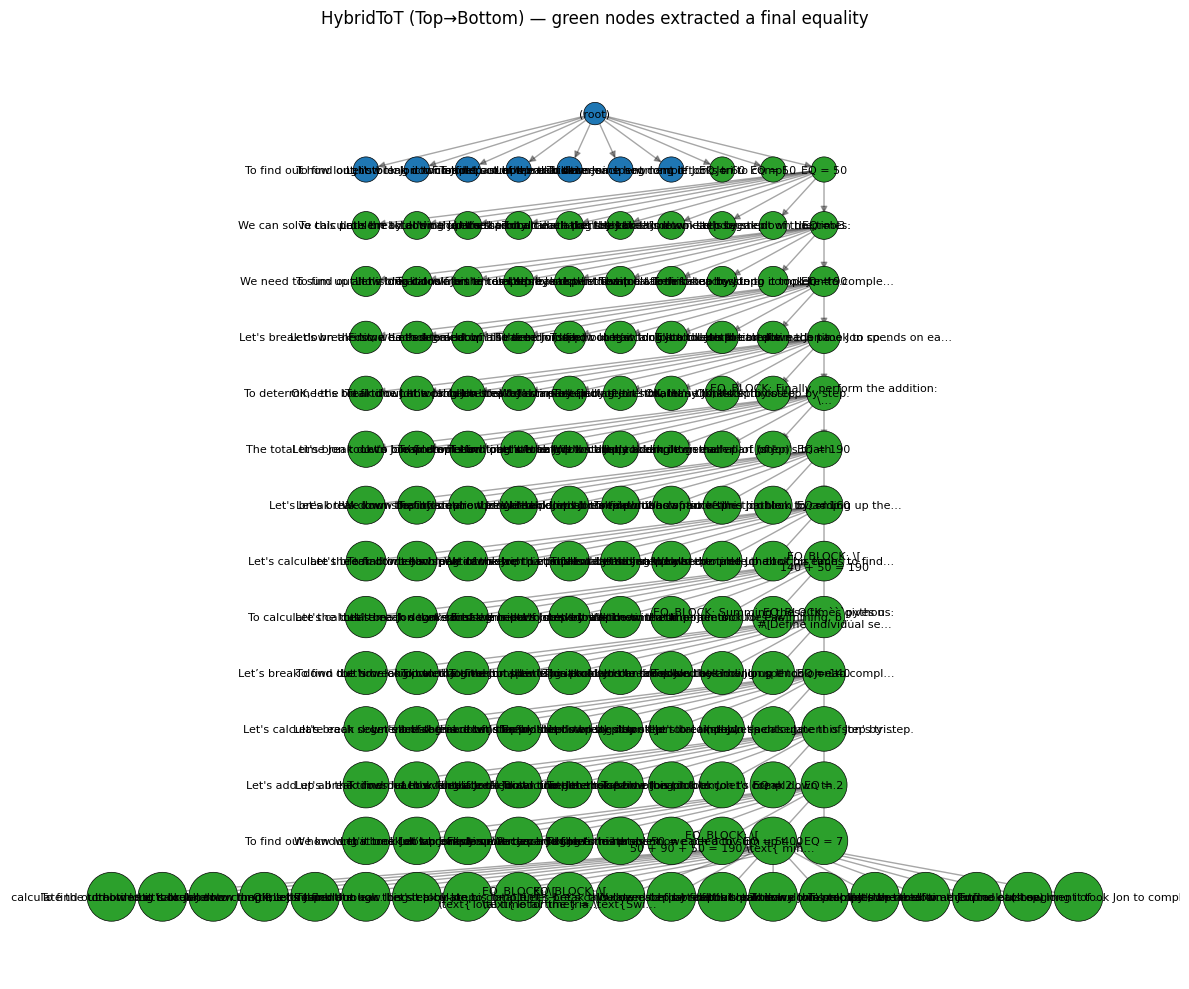


Usage: {'completion_tokens': 38235, 'prompt_tokens': 8850, 'cost': 0.0, 'backend': 'hf-local'}


In [ ]:
# pip install transformers accelerate torch tqdm networkx matplotlib backoff
# (optional) pip install pygraphviz

import os, re, math, random, time, gc, backoff, inspect
from dataclasses import dataclass
from typing import List, Tuple, Optional, Dict
from collections import Counter, deque, defaultdict
from fractions import Fraction
from decimal import Decimal

try:
    import numpy as np
except Exception:
    np = None

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm.auto import tqdm
import networkx as nx
import matplotlib.pyplot as plt

# ================= Config =================
MODEL_NAME = os.getenv("QWEN_MODEL", "Qwen/Qwen2.5-1.5B-Instruct")
DEVICE_MAP = "auto"
MAX_INPUT_TOKENS = 1024
VOTE_T = 1
# DEFAULT_SEED = 777
DEFAULT_SEED = 13

# ================= Seeding =================
GENERATOR = None
def set_seed(seed: Optional[int]):
    global GENERATOR
    if seed is None:
        GENERATOR = None; return
    random.seed(seed)
    if np is not None: np.random.seed(seed)
    torch.manual_seed(seed)
    gen_device = "cuda" if torch.cuda.is_available() else "cpu"
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
    GENERATOR = torch.Generator(device=gen_device).manual_seed(seed)

# ================= Model load =================
gc.collect()
if torch.cuda.is_available(): torch.cuda.empty_cache()

tok = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
if tok.pad_token is None: tok.pad_token = tok.eos_token
mdl = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME, device_map=DEVICE_MAP, torch_dtype="auto", trust_remote_code=True
).eval()

def _supports_kwarg(fn, name: str) -> bool:
    try:
        return name in inspect.signature(fn).parameters
    except (TypeError, ValueError):
        return False
SUPPORTS_GENERATOR = _supports_kwarg(mdl.generate, "generator")

# ================= HF wrappers =================
completion_tokens = 0
prompt_tokens = 0

def _messages_to_text(messages: List[Dict[str, str]]) -> str:
    return "\n".join(f"{(m.get('role') or 'user').upper()}: {m.get('content','')}" for m in messages) + "\nASSISTANT:"

@backoff.on_exception(backoff.expo, (RuntimeError,), max_tries=5)
def _hf_generate(prompt_text: str, temperature: float, max_tokens: int, n: int, stop=None) -> List[str]:
    global completion_tokens, prompt_tokens
    enc = tok(prompt_text, return_tensors="pt", truncation=True, max_length=MAX_INPUT_TOKENS)
    enc = {k: v.to(mdl.device) for k, v in enc.items()}
    outputs, batch, total = [], min(4, n), n
    while total > 0:
        cnt = min(batch, total); total -= cnt
        bi = {k: v.repeat(cnt, 1) for k, v in enc.items()}
        gen_kwargs = dict(do_sample=True, temperature=temperature, top_p=0.92, top_k=60,
                          max_new_tokens=max_tokens, pad_token_id=tok.eos_token_id,
                          eos_token_id=tok.eos_token_id, num_return_sequences=1)
        if SUPPORTS_GENERATOR and GENERATOR is not None: gen_kwargs["generator"] = GENERATOR
        with torch.no_grad():
            gens = mdl.generate(**bi, **gen_kwargs)
        for i in range(cnt):
            txt = tok.decode(gens[i], skip_special_tokens=True)
            gen = txt[len(prompt_text):] if txt.startswith(prompt_text) else txt
            if stop:
                cut = len(gen)
                for s in stop:
                    k = gen.find(s)
                    if k != -1: cut = min(cut, k)
                gen = gen[:cut]
            prompt_tokens += len(tok.encode(prompt_text))
            completion_tokens += len(tok.encode(gen))
            outputs.append(gen.strip())
        if torch.cuda.is_available(): torch.cuda.empty_cache()
    return outputs

def chat_hf(messages, temperature=0.7, max_tokens=256, n=1, stop=None) -> list:
    return _hf_generate(_messages_to_text(messages), temperature=temperature, max_tokens=max_tokens, n=n, stop=stop)
def hf(prompt, temperature=0.7, max_tokens=256, n=1, stop=None) -> list:
    return chat_hf([{"role": "user", "content": prompt}], temperature=temperature, max_tokens=max_tokens, n=n, stop=stop)
def hf_usage(backend="hf-local"):
    return {"completion_tokens": completion_tokens, "prompt_tokens": prompt_tokens, "cost": 0.0, "backend": backend}

# ================= Parsing helpers =================
def _to_fraction(s: str) -> Fraction:
    s = s.strip().rstrip(').,;:')
    if "/" in s:
        num, den = s.split("/", 1); return Fraction(int(num), int(den))
    if "." in s: return Fraction(Decimal(s))
    return Fraction(int(s), 1)

# FINAL-BLOCK parser: only look at the very end of the completion
_eq_rx = re.compile(r'(?<![<>=!])=(?!=)')
_num_rx = re.compile(r'([+-]?(?:\d+/\d+|\d+(?:\.\d+)?))')

def _extract_final_block_equality(text: str) -> Tuple[Optional[Fraction], Optional[str], Optional[str]]:
    text = text.strip()
    if not text: return None, None, None
    blocks = re.split(r'\n\s*\n', text)  # paragraph split
    final_block = blocks[-1].strip()
    lines = [ln.strip() for ln in final_block.splitlines() if ln.strip()]
    # scan from bottom up in final block only
    for line in reversed(lines):
        if re.search(r'answer', line, re.I):  # ignore any "answer" tag
            continue
        found = None
        for m in _eq_rx.finditer(line):
            rhs = line[m.end():]
            nm = _num_rx.search(rhs)
            if nm:
                found = nm.group(1)
        if found:
            try:
                return _to_fraction(found), line, final_block
            except Exception:
                pass
    return None, None, final_block

def parse_last_equality(text: str) -> List[Fraction]:
    v, _, _ = _extract_final_block_equality(text)
    return [v] if v is not None else []

def parse_last_equality_with_line(text: str) -> Tuple[Optional[Fraction], Optional[str], Optional[str]]:
    return _extract_final_block_equality(text)

def read_eqvals_from_info(info: Tuple[str, ...]) -> List[Fraction]:
    vals = []
    for s in info:
        m = re.search(r"\bEQ\s*[:=]\s*([+-]?(?:\d+/\d+|\d*\.\d+|\d+))", s)
        if m:
            try: vals.append(_to_fraction(m.group(1)))
            except Exception: pass
    return vals

def canon(infos: List[str])->Tuple[str,...]:
    out,seen=[],set()
    for s in infos:
        t=s.strip(); k=t.lower()
        if t and k not in seen: seen.add(k); out.append(t[:240])
    return tuple(sorted(out))

def fmt_fraction(q: Fraction) -> str:
    return f"{q}" if q.denominator != 1 else f"{q.numerator}"

# ================= Tree recorder & viz =================
class TreeBook:
    def __init__(self):
        self.G = nx.DiGraph(); self.next_id = 0
        self.attrs: Dict[int, Dict[str, object]] = {}
        self.info: Dict[int, Tuple[str,...]] = {}
    def add_node(self, depth:int, label:str, info:Tuple[str,...]) -> int:
        nid = self.next_id; self.next_id += 1
        self.G.add_node(nid); self.attrs[nid] = {"depth": depth, "label": label}; self.info[nid] = info
        return nid
    def add_edge(self, u:int, v:int): self.G.add_edge(u, v)

def _graphviz_tb(G):
    try:
        from networkx.drawing.nx_agraph import graphviz_layout
        return graphviz_layout(G, prog="dot", args="-Grankdir=TB")
    except Exception:
        return None

def _layered_tb(G, attrs):
    levels: Dict[int, List[int]] = {}
    for n in G.nodes():
        d = attrs[n]["depth"]; levels.setdefault(d, []).append(n)
    pos={}; y_gap=1.8; x_gap=1.6
    for d in sorted(levels.keys()):
        row = sorted(levels[d]); width=(len(row)-1)*x_gap
        for i, nid in enumerate(row):
            pos[nid]=(-width/2+i*x_gap, -d*y_gap)
    return pos

def plot_tree(tb: TreeBook, title="LLM Search Tree (Top→Bottom)"):
    if tb.G.number_of_nodes()==0: print("[viz] Empty tree."); return
    pos = _graphviz_tb(tb.G) or _layered_tb(tb.G, tb.attrs)
    colors, sizes, labels = [], [], {}
    for nid in tb.G.nodes():
        has_eq = any(("EQ" in s.upper()) for s in tb.info[nid])
        colors.append("#2ca02c" if has_eq else "#1f77b4")
        d = tb.attrs[nid]["depth"]; sizes.append(260 + 70*d)
        lbl = tb.attrs[nid]["label"] or "(root)"
        labels[nid] = (lbl[:42]+"…") if len(lbl)>43 else lbl
    plt.figure(figsize=(12, 10))
    nx.draw_networkx_edges(tb.G, pos, alpha=0.35, arrows=True, arrowstyle="-|>", min_target_margin=8)
    nx.draw_networkx_nodes(tb.G, pos, node_color=colors, node_size=sizes, linewidths=0.5, edgecolors="k")
    nx.draw_networkx_labels(tb.G, pos, labels=labels, font_size=8)
    plt.title(title + " — green nodes extracted a final equality")
    plt.axis("off"); plt.tight_layout(); plt.show()

# ============== Voting ==============
def depth_weighted_vote(tb: TreeBook, t: float = 2.0):
    if tb.G.number_of_nodes() == 0: return None, {}, 0, {}
    dmax = max(tb.attrs[n]["depth"] for n in tb.G.nodes())
    weights: Dict[Fraction, float] = defaultdict(float)
    contributions: Dict[Fraction, List[Tuple[int,int,float]]] = defaultdict(list)
    for nid in tb.G.nodes():
        di = tb.attrs[nid]["depth"]; vals = read_eqvals_from_info(tb.info[nid])
        if not vals: continue
        # w = math.exp(- (dmax - di) / max(1e-6, t))          #THIS IS CHANGED
        w = math.exp(- (di) / max(1e-6, t))          #THIS IS CHANGED
        for x in vals:
            weights[x] += w; contributions[x].append((nid, di, w))
    if not weights: return None, {}, dmax, {}
    voted = max(weights.items(), key=lambda kv: kv[1])[0]
    return voted, dict(weights), dmax, contributions

# ================= Hybrid (DFS + BFS) =================
@dataclass
class P:
    max_depth:int=14
    max_nodes:int=600
    min_commit_nodes:int=150
    patience:int=3
    branch:int=18
    T:float=1.6
    bfs_nodes:int=400
    bfs_depth:int=4
    bfs_branch:int=14
    width:int=10
    temp:float=0.95
    max_new_tokens:int=256  # larger so the model reaches its final block

@dataclass
class Ctrl:
    tau:float=0.0; eta:float=0.35
    tau_min:float=-1.0; tau_max:float=6.0
    L_target:float=5.0
    def upd(self,L): self.tau=max(self.tau_min,min(self.tau_max,self.tau+self.eta*(L-self.L_target)))

@dataclass
class Node:
    nid:int; info:Tuple[str,...]; depth:int; value:float; parent:float; H:float=0.0

def sample(prompt: str, n: int, max_new_tokens=256, temperature=0.9) -> List[str]:
    return hf(prompt, temperature=temperature, max_tokens=max_new_tokens, n=n, stop=None)

class HybridToT:
    def __init__(self, p:P):
        self.p=p; self.ctrl=Ctrl(); self.ne=0; self.sv=0; self.vd={}; self.tb=TreeBook()
        self.pending_best = None

    def _H(self, vals):
        if not vals: return 0.0
        T=max(1e-6,self.p.T); m=max(vals); ex=[math.exp((v-m)/T) for v in vals]; Z=sum(ex)
        ps=[e/max(Z,1e-12) for e in ex]; return -sum(p*math.log(max(p,1e-12)) for p in ps)

    def _expand(self, problem_text: str, info: Tuple[str, ...]):
        outs = sample(problem_text, n=self.p.width, max_new_tokens=self.p.max_new_tokens, temperature=self.p.temp)
        scored = []
        for text in outs:
            val, line, block = parse_last_equality_with_line(text)  # FINAL BLOCK ONLY
            merged = list(info); base = 12.0
            if val is not None:
                merged.append(f"EQ = {val}")
                if line:  merged.append(f"EQ_SRC: {line}")
                if block: merged.append(f"EQ_BLOCK: {block[:220]}")
                base = 28.0
            first_line = text.splitlines()[0][:120] if text else ""
            if first_line: merged.append(first_line)
            scored.append((base, canon(merged)))
        return scored

    def _admit(self, node_v, scored, cap):
        out=[]
        for v, merged in sorted(scored, key=lambda x:x[0], reverse=True):
            if v >= self.ctrl.tau: out.append((v, merged))
            if len(out) >= cap: break
        vals=[v for v,_ in out]; return out, vals

    def _goal(self, info)->Tuple[bool, Optional[Fraction]]:
        vals=read_eqvals_from_info(info)
        if vals: return True, Counter(vals).most_common(1)[0][0]
        return False, None

    def _accept_or_buffer(self, path, node, val):
        if self.ne >= self.p.min_commit_nodes: return path, True
        self.pending_best = (path, val); return path, False

    def _bfs(self, problem_text: str, start, base_path, pbar=None):
        q = deque([(start, base_path)]); used=0
        while q and used < self.p.bfs_nodes and self.ne < self.p.max_nodes:
            node, path = q.popleft()
            ok, val = self._goal(node.info)
            if ok:
                if val is not None:
                    node.info = canon(list(node.info) + [f"EQ = {val}"])
                    self.tb.info[node.nid] = node.info
                return self._accept_or_buffer(path, node, val)
            if node.depth >= self.p.max_depth:
                used += 1; continue
            key=node.info
            if key in self.vd and self.vd[key] <= node.depth:
                used += 1; continue
            if key not in self.vd: self.sv += 1
            self.vd[key] = node.depth
            kids = self._expand(problem_text, node.info)
            scored=[]
            for base, merged in kids:
                v = base - 0.04*(node.depth+1); scored.append((v, merged)); self.ne += 1
                if pbar: pbar.update(1)
            admitted,_ = self._admit(node.value, scored, self.p.bfs_branch)
            for v, merged in admitted:
                delta=[s for s in merged if s not in node.info]
                label = next((s for s in delta if s.startswith("EQ =")), delta[0] if delta else "(step)")
                child_nid = self.tb.add_node(depth=node.depth+1, label=label, info=merged)
                self.tb.add_edge(node.nid, child_nid)
                child = Node(nid=child_nid, info=merged, depth=node.depth+1, value=v, parent=node.value)
                if child.depth - start.depth <= self.p.bfs_depth: q.append((child, path+[child]))
            used += 1
        return base_path, False

    def solve(self, problem_text: str, seed: Optional[int] = DEFAULT_SEED):
        set_seed(seed)
        self.ctrl=Ctrl(tau=-0.20); self.ne=0; self.sv=0; self.vd.clear(); self.pending_best=None
        root_info = canon([]); root_nid = self.tb.add_node(depth=0, label="(root)", info=root_info)
        root = Node(nid=root_nid, info=root_info, depth=0, value=0.0, parent=-1e-9)
        stack, path = [root], [root]; best=None; patience=0

        with tqdm(total=self.p.max_nodes, desc="Nodes", unit="node",
                  bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{rate_fmt}]") as pbar:
            while stack and self.ne < self.p.max_nodes:
                node = stack.pop(); path = path[:node.depth] + [node]
                if self.ne % 100 == 0:
                    print(f"[d={node.depth}] V={node.value:.2f} τ={self.ctrl.tau:.2f} facts={len(node.info)}")

                ok, val = self._goal(node.info)
                if ok:
                    if val is not None:
                        node.info = canon(list(node.info) + [f"EQ = {val}"]); self.tb.info[node.nid] = node.info
                    path, accept = self._accept_or_buffer(path, node, val)
                    if accept: best=path; break

                if node.depth >= self.p.max_depth:
                    self.ctrl.upd(len(path)-1)
                    path, ok = self._bfs(problem_text, path[-1], path, pbar)
                    if ok: best=path; break
                    patience=0; continue

                key=node.info
                if key in self.vd and self.vd[key] <= node.depth:
                    patience += 1
                    if patience >= self.p.patience:
                        path, ok = self._bfs(problem_text, path[-1], path, pbar)
                        if ok: best=path; break
                        patience=0
                    continue

                if key not in self.vd: self.sv += 1
                self.vd[key] = node.depth

                kids = self._expand(problem_text, node.info)
                vals, scored = [], []
                for base, merged in kids:
                    v = base - 0.04*(node.depth+1)
                    scored.append((v, merged)); vals.append(v); self.ne += 1; pbar.update(1)
                node.H = self._H(vals) if vals else 0.0
                admitted,_ = self._admit(node.value, scored, self.p.branch)
                if not admitted:
                    patience += 1
                    if patience >= self.p.patience:
                        path, ok = self._bfs(problem_text, path[-1], path, pbar)
                        if ok: best=path; break
                        patience=0
                    continue
                else:
                    patience=0
                for v, merged in reversed(admitted):
                    delta=[s for s in merged if s not in node.info]
                    label = next((s for s in delta if s.startswith("EQ =")), delta[0] if delta else "(step)")
                    child_nid = self.tb.add_node(depth=node.depth+1, label=label, info=merged)
                    self.tb.add_edge(node.nid, child_nid)
                    stack.append(Node(nid=child_nid, info=merged, depth=node.depth+1, value=v, parent=node.value))

        if best is None and self.pending_best is not None:
            best = self.pending_best[0]

        voted, weights, dmax, contrib = depth_weighted_vote(self.tb, t=VOTE_T)
        final_info = best[-1].info if best else path[-1].info
        return {"voted_value": voted, "weights": weights, "dmax": dmax, "contrib": contrib,
                "facts": list(final_info), "stats": {"found": best is not None, "nodes": self.ne, "states": self.sv},
                "tree": self.tb}

# ================= Problem & Run =================
if __name__ == "__main__":
    PROBLEM = (
        "Jon runs a triathlon. It takes him 50 minutes for\n"
        "the swim, an hour and 30 minutes for the bike\n"
        "ride and 50 minutes for the run.\n"
        "How long in minutes did it take Jon to complete the triathlon?\n"
    )

    solver = HybridToT(P())
    res = solver.solve(PROBLEM, seed=DEFAULT_SEED)

    print("\n=== RESULTS (Depth-weighted voting over entire tree) ===")
    print("Deepest depth (dmax):", res["dmax"])
    if res["weights"]:
        print("All candidate values (sorted by total weight):")
        for a, w in sorted(res["weights"].items(), key=lambda kv: (-kv[1], kv[0])):
            details = res["contrib"].get(a, [])
            depths = [d for (_, d, _) in details]
            cnt = len(details)
            dmin = min(depths) if depths else "-"
            dmax = max(depths) if depths else "-"
            print(f"  VAL={fmt_fraction(a):>4} | total_weight={w:.6f} | count={cnt:>3} | depth_range=[{dmin}, {dmax}]")
            for nid, d, wi in sorted(details, key=lambda t: (-t[2], -t[1]))[:6]:
                print(f"      - node {nid:>4} @ d={d:<2}  w={wi:.6f}")
    else:
        print("No values found in tree.")

    voted = res["voted_value"]
    print("\nVoted value (t=%.2f):" % VOTE_T, fmt_fraction(voted) if voted is not None else None)
    print("Found path:", res["stats"]["found"])
    print("Nodes evaluated:", res["stats"]["nodes"])
    print("States visited:", res["stats"]["states"])

    if voted is not None and res["contrib"].get(voted):
        tb = res["tree"]
        contribs = sorted(res["contrib"][voted], key=lambda t: (-t[2], -t[1]))
        print("\nTop vote source lines for the winning value (FINAL BLOCK ONLY):")
        shown = 0
        for nid, d, wi in contribs:
            info = tb.info.get(nid, ())
            srcs  = [s[8:] for s in info if s.upper().startswith("EQ_SRC: ")]
            block = [s[10:] for s in info if s.upper().startswith("EQ_BLOCK: ")]
            if srcs:
                print(f"  • node {nid} @ depth {d} (w={wi:.6f})")
                print(f"    EQ_SRC: {srcs[0]}")
                if block: print(f"    FINAL_BLOCK: {block[0]}")
                shown += 1
            if shown >= 3: break
        if shown == 0:
            print("  (No EQ_SRC captured in final block.)")

    print("\nFacts containing 'EQ' on best path:")
    for f in res["facts"]:
        if "EQ" in f.upper():
            print("-", f)

    plot_tree(res["tree"], title="HybridToT (Top→Bottom)")

    print("\nUsage:", hf_usage())


## Triathlon problem refined (dec 3, 2025): Success later work

In [ ]:
pip install backoff

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

Nodes:   0%|          | 0/600 [?node/s]

[d=0] V=0.00 τ=-0.20 facts=0 guess=- coh=- correct=-
[d=10] V=2.50 τ=-0.20 facts=16 guess=190 coh=0.50 correct=1.00
[d=13] V=2.32 τ=6.00 facts=21 guess=190 coh=0.50 correct=1.00
[d=12] V=1.56 τ=6.00 facts=21 guess=190 coh=0.33 correct=1.00
[d=10] V=2.50 τ=6.00 facts=16 guess=190 coh=0.50 correct=1.00
[d=9] V=2.56 τ=6.00 facts=15 guess=190 coh=0.50 correct=1.00

=== RESULTS (Depth-weighted voting over entire tree) ===
Deepest depth (dmax): 14
All candidate values (sorted by total weight):
  VAL= 190 | total_weight=28.209021 | count= 61 | depth_range=[6, 14]
      - node  131 @ d=14  w=1.800000
      - node  132 @ d=14  w=1.800000
      - node  133 @ d=14  w=1.800000
      - node  134 @ d=14  w=1.800000
      - node  135 @ d=14  w=1.800000
      - node  136 @ d=14  w=1.800000
  VAL=  50 | total_weight=0.046076 | count= 68 | depth_range=[1, 8]
      - node   71 @ d=8   w=0.003222
      - node   72 @ d=8   w=0.003222
      - node   73 @ d=8   w=0.003222
      - node   74 @ d=8   w=0.003222

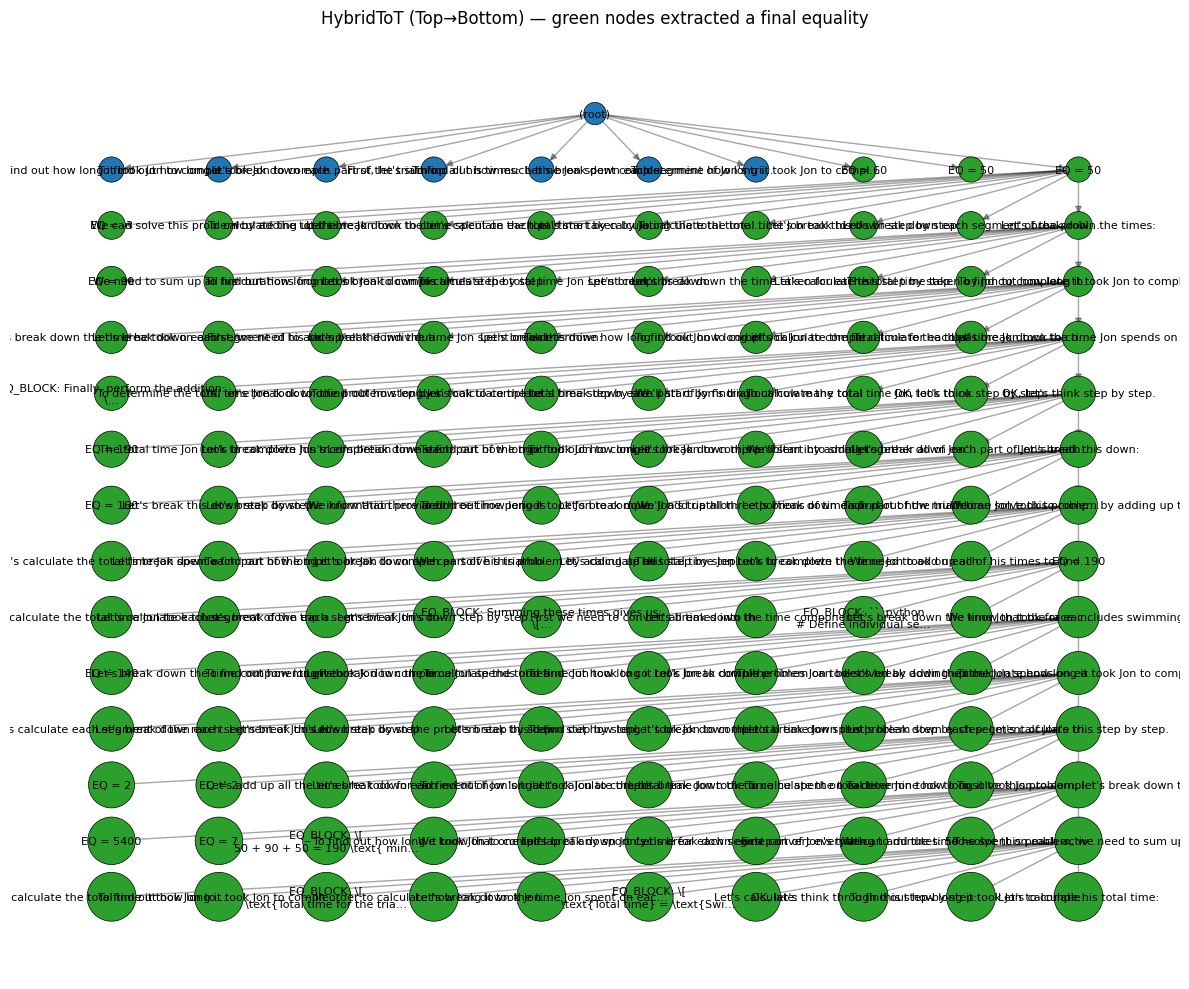


Usage: {'completion_tokens': 152963, 'prompt_tokens': 35400, 'cost': 0.0, 'backend': 'hf-local'}


In [ ]:
# pip install transformers accelerate torch tqdm networkx matplotlib backoff
# (optional) pip install pygraphviz

import os, re, math, random, gc, backoff, inspect
from dataclasses import dataclass
from typing import List, Tuple, Optional, Dict
from collections import Counter, deque, defaultdict
from fractions import Fraction
from decimal import Decimal

try:
    import numpy as np
except Exception:
    np = None

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm.auto import tqdm
import networkx as nx
import matplotlib.pyplot as plt

# ================= Config =================
MODEL_NAME = os.getenv("QWEN_MODEL", "Qwen/Qwen2.5-1.5B-Instruct")
DEVICE_MAP = "auto"
MAX_INPUT_TOKENS = 1024
VOTE_T = 1.0
DEFAULT_SEED = 13

# ================= Seeding =================
GENERATOR = None
def set_seed(seed: Optional[int]):
    global GENERATOR
    if seed is None:
        GENERATOR = None
        return
    random.seed(seed)
    if np is not None:
        np.random.seed(seed)
    torch.manual_seed(seed)
    gen_device = "cuda" if torch.cuda.is_available() else "cpu"
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    GENERATOR = torch.Generator(device=gen_device).manual_seed(seed)

# ================= Model load =================
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

tok = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
if tok.pad_token is None:
    tok.pad_token = tok.eos_token
mdl = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map=DEVICE_MAP,
    torch_dtype="auto",
    trust_remote_code=True
).eval()

def _supports_kwarg(fn, name: str) -> bool:
    try:
        return name in inspect.signature(fn).parameters
    except (TypeError, ValueError):
        return False

SUPPORTS_GENERATOR = _supports_kwarg(mdl.generate, "generator")

# ================= HF wrappers =================
completion_tokens = 0
prompt_tokens = 0

def _messages_to_text(messages: List[Dict[str, str]]) -> str:
    return "\n".join(
        f"{(m.get('role') or 'user').upper()}: {m.get('content','')}"
        for m in messages
    ) + "\nASSISTANT:"

@backoff.on_exception(backoff.expo, (RuntimeError,), max_tries=5)
def _hf_generate(prompt_text: str, temperature: float, max_tokens: int, n: int, stop=None) -> List[str]:
    global completion_tokens, prompt_tokens
    enc = tok(prompt_text, return_tensors="pt", truncation=True, max_length=MAX_INPUT_TOKENS)
    enc = {k: v.to(mdl.device) for k, v in enc.items()}
    outputs = []
    batch = min(4, n)
    total = n
    while total > 0:
        cnt = min(batch, total)
        total -= cnt
        bi = {k: v.repeat(cnt, 1) for k, v in enc.items()}
        gen_kwargs = dict(
            do_sample=True,
            temperature=temperature,
            top_p=0.92,
            top_k=60,
            max_new_tokens=max_tokens,
            pad_token_id=tok.eos_token_id,
            eos_token_id=tok.eos_token_id,
            num_return_sequences=1,
        )
        if SUPPORTS_GENERATOR and GENERATOR is not None:
            gen_kwargs["generator"] = GENERATOR
        with torch.no_grad():
            gens = mdl.generate(**bi, **gen_kwargs)
        for i in range(cnt):
            txt = tok.decode(gens[i], skip_special_tokens=True)
            gen = txt[len(prompt_text):] if txt.startswith(prompt_text) else txt
            if stop:
                cut = len(gen)
                for s in stop:
                    k = gen.find(s)
                    if k != -1:
                        cut = min(cut, k)
                gen = gen[:cut]
            prompt_tokens += len(tok.encode(prompt_text))
            completion_tokens += len(tok.encode(gen))
            outputs.append(gen.strip())
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    return outputs

def chat_hf(messages, temperature=0.7, max_tokens=256, n=1, stop=None) -> list:
    return _hf_generate(_messages_to_text(messages), temperature=temperature, max_tokens=max_tokens, n=n, stop=stop)

def hf(prompt, temperature=0.7, max_tokens=256, n=1, stop=None) -> list:
    return chat_hf([{"role": "user", "content": prompt}], temperature=temperature, max_tokens=max_tokens, n=n, stop=stop)

def hf_usage(backend="hf-local"):
    return {
        "completion_tokens": completion_tokens,
        "prompt_tokens": prompt_tokens,
        "cost": 0.0,
        "backend": backend,
    }

# ================= Parsing helpers =================
def _to_fraction(s: str) -> Fraction:
    s = s.strip().rstrip(').,;:')
    if "/" in s:
        num, den = s.split("/", 1)
        return Fraction(int(num), int(den))
    if "." in s:
        return Fraction(Decimal(s))
    return Fraction(int(s), 1)

_eq_rx = re.compile(r'(?<![<>=!])=(?!=)')
_num_rx = re.compile(r'([+-]?(?:\d+/\d+|\d+(?:\.\d+)?))')

def _extract_final_block_equality(text: str) -> Tuple[Optional[Fraction], Optional[str], Optional[str]]:
    text = text.strip()
    if not text:
        return None, None, None
    blocks = re.split(r'\n\s*\n', text)
    final_block = blocks[-1].strip()
    lines = [ln.strip() for ln in final_block.splitlines() if ln.strip()]
    for line in reversed(lines):
        if re.search(r'answer', line, re.I):
            continue
        found = None
        for m in _eq_rx.finditer(line):
            rhs = line[m.end():]
            nm = _num_rx.search(rhs)
            if nm:
                found = nm.group(1)
        if found:
            try:
                return _to_fraction(found), line, final_block
            except Exception:
                pass
    return None, None, final_block

def parse_last_equality(text: str) -> List[Fraction]:
    v, _, _ = _extract_final_block_equality(text)
    return [v] if v is not None else []

def parse_last_equality_with_line(text: str) -> Tuple[Optional[Fraction], Optional[str], Optional[str]]:
    return _extract_final_block_equality(text)

def read_eqvals_from_info(info: Tuple[str, ...]) -> List[Fraction]:
    vals = []
    for s in info:
        m = re.search(r"\bEQ\s*[:=]\s*([+-]?(?:\d+/\d+|\d*\.\d+|\d+))", s)
        if m:
            try:
                vals.append(_to_fraction(m.group(1)))
            except Exception:
                pass
    return vals

def read_eqsrcs_from_info(info: Tuple[str, ...]) -> List[str]:
    srcs = []
    for s in info:
        if s.upper().startswith("EQ_SRC:"):
            srcs.append(s[8:].strip())
    return srcs

def canon(infos: List[str]) -> Tuple[str, ...]:
    out, seen = [], set()
    for s in infos:
        t = s.strip()
        k = t.lower()
        if t and k not in seen:
            seen.add(k)
            out.append(t[:240])
    return tuple(sorted(out))

def fmt_fraction(q: Fraction) -> str:
    return f"{q}" if q.denominator != 1 else f"{q.numerator}"

# ================= Arithmetic consistency checker =================
def _safe_eval_expr(expr: str) -> Optional[Fraction]:
    """
    Very small arithmetic parser for expressions like:
       50 + 90 + 50
       1/2 + 3/4
       (10 * 3) - 5
    Only allows digits, /, +, -, *, ., parentheses, and spaces.
    """
    expr = expr.strip()
    if not expr:
        return None
    if not re.fullmatch(r"[0-9\+\-\*\/\.\(\)\s]+", expr):
        return None
    try:
        val = eval(expr, {"__builtins__": {}}, {})
    except Exception:
        return None
    try:
        if isinstance(val, int):
            return Fraction(val, 1)
        return Fraction(Decimal(str(val)))
    except Exception:
        return None

def arithmetic_correctness_from_srcs(srcs: List[str]) -> Tuple[int, int]:
    """
    Returns (#correct, #incorrect) arithmetically checked equalities
    from EQ_SRC lines.
    """
    correct = 0
    incorrect = 0
    for line in srcs:
        m = _eq_rx.search(line)
        if not m:
            continue
        lhs = line[:m.start()]
        rhs = line[m.end():]
        vl = _safe_eval_expr(lhs)
        vr = _safe_eval_expr(rhs)
        if vl is None or vr is None:
            continue
        if vl == vr:
            correct += 1
        else:
            incorrect += 1
    return correct, incorrect

# ================= Tree recorder & viz =================
class TreeBook:
    def __init__(self):
        self.G = nx.DiGraph()
        self.next_id = 0
        self.attrs: Dict[int, Dict[str, object]] = {}
        self.info: Dict[int, Tuple[str, ...]] = {}

    def add_node(self, depth: int, label: str, info: Tuple[str, ...]) -> int:
        nid = self.next_id
        self.next_id += 1
        self.G.add_node(nid)
        self.attrs[nid] = {"depth": depth, "label": label}
        self.info[nid] = info
        return nid

    def add_edge(self, u: int, v: int):
        self.G.add_edge(u, v)

def _graphviz_tb(G):
    try:
        from networkx.drawing.nx_agraph import graphviz_layout
        return graphviz_layout(G, prog="dot", args="-Grankdir=TB")
    except Exception:
        return None

def _layered_tb(G, attrs):
    levels: Dict[int, List[int]] = {}
    for n in G.nodes():
        d = attrs[n]["depth"]
        levels.setdefault(d, []).append(n)
    pos = {}
    y_gap = 1.8
    x_gap = 1.6
    for d in sorted(levels.keys()):
        row = sorted(levels[d])
        width = (len(row) - 1) * x_gap
        for i, nid in enumerate(row):
            pos[nid] = (-width / 2 + i * x_gap, -d * y_gap)
    return pos

def plot_tree(tb: TreeBook, title="LLM Search Tree (Top→Bottom)"):
    if tb.G.number_of_nodes() == 0:
        print("[viz] Empty tree.")
        return
    pos = _graphviz_tb(tb.G) or _layered_tb(tb.G, tb.attrs)
    colors, sizes, labels = [], [], {}
    for nid in tb.G.nodes():
        has_eq = any(("EQ" in s.upper()) for s in tb.info[nid])
        colors.append("#2ca02c" if has_eq else "#1f77b4")
        d = tb.attrs[nid]["depth"]
        sizes.append(260 + 70 * d)
        lbl = tb.attrs[nid]["label"] or "(root)"
        labels[nid] = (lbl[:42] + "…") if len(lbl) > 43 else lbl
    plt.figure(figsize=(12, 10))
    nx.draw_networkx_edges(
        tb.G, pos, alpha=0.35, arrows=True,
        arrowstyle="-|>", min_target_margin=8
    )
    nx.draw_networkx_nodes(
        tb.G, pos, node_color=colors,
        node_size=sizes, linewidths=0.5, edgecolors="k"
    )
    nx.draw_networkx_labels(tb.G, pos, labels=labels, font_size=8)
    plt.title(title + " — green nodes extracted a final equality")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# ============== Voting (improved bottom-up) ==============
def depth_weighted_vote(tb: TreeBook, t: float = 2.0):
    """
    Final aggregator (improved):
      - Each node votes ONLY for its local best (mode) EQ value.
      - Votes are depth-weighted from the bottom of the tree:
            w_depth = exp(-(dmax - depth) / t)
        so deeper conclusions count more.
      - Weight is further scaled by:
            coherence   = best_count / total_EQs
            correct_rate = fraction of arithmetically correct EQ_SRC lines
            factor = 0.3 + coherence + correct_rate
    """
    if tb.G.number_of_nodes() == 0:
        return None, {}, 0, {}

    dmax = max(tb.attrs[n]["depth"] for n in tb.G.nodes())
    weights: Dict[Fraction, float] = defaultdict(float)
    contributions: Dict[Fraction, List[Tuple[int, int, float]]] = defaultdict(list)

    for nid in tb.G.nodes():
        di = tb.attrs[nid]["depth"]
        info = tb.info[nid]

        vals = read_eqvals_from_info(info)
        if not vals:
            continue

        counts = Counter(vals)
        best_val, best_count = counts.most_common(1)[0]
        total = len(vals)
        coherence = best_count / max(1, total)

        srcs = read_eqsrcs_from_info(info)
        correct, incorrect = arithmetic_correctness_from_srcs(srcs)
        total_checked = correct + incorrect
        correct_rate = correct / total_checked if total_checked > 0 else 0.0

        T = max(1e-6, t)
        w_depth = math.exp(-(dmax - di) / T)

        factor = 0.3 + coherence + correct_rate  # >= 0.3
        w_node = w_depth * factor

        weights[best_val] += w_node
        contributions[best_val].append((nid, di, w_node))

    if not weights:
        return None, {}, dmax, {}

    voted = max(weights.items(), key=lambda kv: kv[1])[0]
    return voted, dict(weights), dmax, contributions

# ================= Hybrid (DFS + BFS) =================
@dataclass
class P:
    max_depth: int = 14
    max_nodes: int = 600
    min_commit_nodes: int = 150
    patience: int = 3
    branch: int = 18
    T: float = 1.6
    bfs_nodes: int = 400
    bfs_depth: int = 4
    bfs_branch: int = 14
    width: int = 10
    temp: float = 0.95
    max_new_tokens: int = 256  # allow model to reach final block

@dataclass
class Ctrl:
    tau: float = 0.0
    eta: float = 0.35
    tau_min: float = -1.0
    tau_max: float = 6.0
    L_target: float = 5.0

    def upd(self, L):
        self.tau = max(
            self.tau_min,
            min(self.tau_max, self.tau + self.eta * (L - self.L_target)),
        )

@dataclass
class Node:
    nid: int
    info: Tuple[str, ...]
    depth: int
    value: float
    parent: float
    H: float = 0.0

def sample(prompt: str, n: int, max_new_tokens=256, temperature=0.9) -> List[str]:
    return hf(prompt, temperature=temperature, max_tokens=max_new_tokens, n=n, stop=None)

class HybridToT:
    """
    Hybrid DFS + BFS Tree-of-Thought with a *structural* value function.

    - No access to ground-truth answers.
    - Value depends on:
        * self-consistency of EQ values on the path,
        * arithmetic correctness of EQ_SRC equalities (LHS vs RHS),
        * depth (shallower preferred).
    """

    def __init__(self, p: P):
        self.p = p
        self.ctrl = Ctrl()
        self.ne = 0           # nodes evaluated (LLM samples)
        self.sv = 0           # states visited (unique info sets)
        self.vd: Dict[Tuple[str, ...], int] = {}
        self.tb = TreeBook()
        self.pending_best = None

    def _H(self, vals: List[float]) -> float:
        if not vals:
            return 0.0
        T = max(1e-6, self.p.T)
        m = max(vals)
        ex = [math.exp((v - m) / T) for v in vals]
        Z = sum(ex)
        ps = [e / max(Z, 1e-12) for e in ex]
        return -sum(p * math.log(max(p, 1e-12)) for p in ps)

    def _expand(self, problem_text: str, info: Tuple[str, ...]) -> List[Tuple[str, ...]]:
        outs = sample(
            problem_text,
            n=self.p.width,
            max_new_tokens=self.p.max_new_tokens,
            temperature=self.p.temp,
        )
        children = []
        for text in outs:
            val, line, block = parse_last_equality_with_line(text)
            merged = list(info)
            if val is not None:
                merged.append(f"EQ = {val}")
                if line:
                    merged.append(f"EQ_SRC: {line}")
                if block:
                    merged.append(f"EQ_BLOCK: {block[:220]}")
            first_line = text.splitlines()[0][:120] if text else ""
            if first_line:
                merged.append(first_line)
            children.append(canon(merged))
        return children

    def _value(self, info: Tuple[str, ...], depth: int) -> float:
        vals = read_eqvals_from_info(info)
        srcs = read_eqsrcs_from_info(info)
        correct, incorrect = arithmetic_correctness_from_srcs(srcs)
        total_checked = correct + incorrect
        correct_rate = correct / total_checked if total_checked > 0 else 0.0

        if not vals:
            return 2.0 * correct_rate - 0.08 * depth

        counts = Counter(vals)
        best_val, best_count = counts.most_common(1)[0]
        total = len(vals)
        unique = len(counts)

        coherence = best_count / max(1, total)
        support = best_count
        conflict = max(0, unique - 1)

        v = (
            2.5 * coherence
            + 0.25 * support
            - 0.4 * conflict
            + 2.0 * correct_rate
            - 0.06 * depth
        )
        return float(v)

    def _admit(self, node_v: float, scored: List[Tuple[float, Tuple[str, ...]]], cap: int):
        out = []
        for v, merged in sorted(scored, key=lambda x: x[0], reverse=True):
            if v >= self.ctrl.tau:
                out.append((v, merged))
            if len(out) >= cap:
                break
        vals = [v for v, _ in out]
        return out, vals

    def _goal(self, info: Tuple[str, ...]) -> Tuple[bool, Optional[Fraction]]:
        vals = read_eqvals_from_info(info)
        if not vals:
            return False, None
        counts = Counter(vals)
        best_val, best_count = counts.most_common(1)[0]
        total = len(vals)

        srcs = read_eqsrcs_from_info(info)
        correct, incorrect = arithmetic_correctness_from_srcs(srcs)
        total_checked = correct + incorrect
        correct_rate = correct / total_checked if total_checked > 0 else 0.0

        if (
            best_count >= 2
            and best_count >= 0.6 * total
            and correct_rate >= 0.6
            and incorrect == 0
        ):
            return True, best_val
        return False, None

    def _accept_or_buffer(self, path, node, val):
        if self.ne >= self.p.min_commit_nodes:
            return path, True
        self.pending_best = (path, val)
        return path, False

    def _bfs(self, problem_text: str, start: Node, base_path, pbar=None):
        q = deque([(start, base_path)])
        used = 0
        while q and used < self.p.bfs_nodes and self.ne < self.p.max_nodes:
            node, path = q.popleft()

            ok, val = self._goal(node.info)
            if ok:
                if val is not None:
                    node.info = canon(list(node.info) + [f"EQ = {val}"])
                    self.tb.info[node.nid] = node.info
                return self._accept_or_buffer(path, node, val)

            if node.depth >= self.p.max_depth:
                used += 1
                continue

            key = node.info
            if key in self.vd and self.vd[key] <= node.depth:
                used += 1
                continue
            if key not in self.vd:
                self.sv += 1
            self.vd[key] = node.depth

            children_infos = self._expand(problem_text, node.info)
            scored = []
            for merged in children_infos:
                v = self._value(merged, node.depth + 1)
                scored.append((v, merged))
                self.ne += 1
                if pbar:
                    pbar.update(1)

            admitted, _ = self._admit(node.value, scored, self.p.bfs_branch)
            for v, merged in admitted:
                delta = [s for s in merged if s not in node.info]
                label = next(
                    (s for s in delta if s.startswith("EQ =")),
                    delta[0] if delta else "(step)",
                )
                child_nid = self.tb.add_node(
                    depth=node.depth + 1, label=label, info=merged
                )
                self.tb.add_edge(node.nid, child_nid)
                child = Node(
                    nid=child_nid,
                    info=merged,
                    depth=node.depth + 1,
                    value=v,
                    parent=node.value,
                )
                if child.depth - start.depth <= self.p.bfs_depth:
                    q.append((child, path + [child]))
            used += 1
        return base_path, False

    def solve(self, problem_text: str, seed: Optional[int] = DEFAULT_SEED):
        set_seed(seed)
        self.ctrl = Ctrl(tau=-0.20)
        self.ne = 0
        self.sv = 0
        self.vd.clear()
        self.pending_best = None

        root_info = canon([])
        root_nid = self.tb.add_node(depth=0, label="(root)", info=root_info)
        root = Node(nid=root_nid, info=root_info, depth=0, value=0.0, parent=-1e-9)

        stack = [root]
        path = [root]
        best = None
        patience = 0

        with tqdm(
            total=self.p.max_nodes,
            desc="Nodes",
            unit="node",
            bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{rate_fmt}]",
        ) as pbar:
            while stack and self.ne < self.p.max_nodes:
                node = stack.pop()
                path = path[: node.depth] + [node]

                vals_here = read_eqvals_from_info(node.info)
                best_guess_str = "-"
                coherence_str = "-"
                correct_rate_str = "-"
                if vals_here:
                    counts = Counter(vals_here)
                    guess, best_count = counts.most_common(1)[0]
                    total = len(vals_here)
                    coherence = best_count / max(1, total)
                    srcs_here = read_eqsrcs_from_info(node.info)
                    correct, incorrect = arithmetic_correctness_from_srcs(srcs_here)
                    total_checked = correct + incorrect
                    correct_rate = correct / total_checked if total_checked > 0 else 0.0
                    best_guess_str = fmt_fraction(guess)
                    coherence_str = f"{coherence:.2f}"
                    correct_rate_str = f"{correct_rate:.2f}"
                if self.ne % 100 == 0:
                    print(
                        f"[d={node.depth}] V={node.value:.2f} τ={self.ctrl.tau:.2f} "
                        f"facts={len(node.info)} "
                        f"guess={best_guess_str} coh={coherence_str} correct={correct_rate_str}"
                    )

                ok, val = self._goal(node.info)
                if ok:
                    if val is not None:
                        node.info = canon(list(node.info) + [f"EQ = {val}"])
                        self.tb.info[node.nid] = node.info
                    path, accept = self._accept_or_buffer(path, node, val)
                    if accept:
                        best = path
                        break

                if node.depth >= self.p.max_depth:
                    self.ctrl.upd(len(path) - 1)
                    path, ok = self._bfs(problem_text, path[-1], path, pbar)
                    if ok:
                        best = path
                        break
                    patience = 0
                    continue

                key = node.info
                if key in self.vd and self.vd[key] <= node.depth:
                    patience += 1
                    if patience >= self.p.patience:
                        path, ok = self._bfs(problem_text, path[-1], path, pbar)
                        if ok:
                            best = path
                            break
                        patience = 0
                    continue

                if key not in self.vd:
                    self.sv += 1
                self.vd[key] = node.depth

                children_infos = self._expand(problem_text, node.info)
                vals, scored = [], []
                for merged in children_infos:
                    v = self._value(merged, node.depth + 1)
                    scored.append((v, merged))
                    vals.append(v)
                    self.ne += 1
                    pbar.update(1)

                node.H = self._H(vals) if vals else 0.0
                admitted, _ = self._admit(node.value, scored, self.p.branch)
                if not admitted:
                    patience += 1
                    if patience >= self.p.patience:
                        path, ok = self._bfs(problem_text, path[-1], path, pbar)
                        if ok:
                            best = path
                            break
                        patience = 0
                    continue
                else:
                    patience = 0

                for v, merged in reversed(admitted):
                    delta = [s for s in merged if s not in node.info]
                    label = next(
                        (s for s in delta if s.startswith("EQ =")),
                        delta[0] if delta else "(step)",
                    )
                    child_nid = self.tb.add_node(
                        depth=node.depth + 1, label=label, info=merged
                    )
                    self.tb.add_edge(node.nid, child_nid)
                    stack.append(
                        Node(
                            nid=child_nid,
                            info=merged,
                            depth=node.depth + 1,
                            value=v,
                            parent=node.value,
                        )
                    )

        if best is None and self.pending_best is not None:
            best = self.pending_best[0]

        voted, weights, dmax, contrib = depth_weighted_vote(self.tb, t=VOTE_T)
        final_info = best[-1].info if best else path[-1].info
        return {
            "voted_value": voted,
            "weights": weights,
            "dmax": dmax,
            "contrib": contrib,
            "facts": list(final_info),
            "stats": {"found": best is not None, "nodes": self.ne, "states": self.sv},
            "tree": self.tb,
        }

# ================= Problem & Run =================
if __name__ == "__main__":
    PROBLEM = (
        "Jon runs a triathlon. It takes him 50 minutes for\n"
        "the swim, an hour and 30 minutes for the bike\n"
        "ride and 50 minutes for the run.\n"
        "How long in minutes did it take Jon to complete the triathlon?\n"
    )

    solver = HybridToT(P())
    res = solver.solve(PROBLEM, seed=DEFAULT_SEED)

    print("\n=== RESULTS (Depth-weighted voting over entire tree) ===")
    print("Deepest depth (dmax):", res["dmax"])
    if res["weights"]:
        print("All candidate values (sorted by total weight):")
        for a, w in sorted(res["weights"].items(), key=lambda kv: (-kv[1], kv[0])):
            details = res["contrib"].get(a, [])
            depths = [d for (_, d, _) in details]
            cnt = len(details)
            dmin = min(depths) if depths else "-"
            dmax_v = max(depths) if depths else "-"
            print(
                f"  VAL={fmt_fraction(a):>4} | total_weight={w:.6f} | "
                f"count={cnt:>3} | depth_range=[{dmin}, {dmax_v}]"
            )
            for nid, d, wi in sorted(details, key=lambda t: (-t[2], -t[1]))[:6]:
                print(f"      - node {nid:>4} @ d={d:<2}  w={wi:.6f}")
    else:
        print("No values found in tree.")

    voted = res["voted_value"]
    print("\nVoted value (t=%.2f):" % VOTE_T, fmt_fraction(voted) if voted is not None else None)
    print("Found path:", res["stats"]["found"])
    print("Nodes evaluated:", res["stats"]["nodes"])
    print("States visited:", res["stats"]["states"])

    if voted is not None and res["contrib"].get(voted):
        tb = res["tree"]
        contribs = sorted(res["contrib"][voted], key=lambda t: (-t[2], -t[1]))
        print("\nTop vote source lines for the winning value (FINAL BLOCK ONLY):")
        shown = 0
        for nid, d, wi in contribs:
            info = tb.info.get(nid, ())
            srcs = [s[8:] for s in info if s.upper().startswith("EQ_SRC: ")]
            block = [s[10:] for s in info if s.upper().startswith("EQ_BLOCK: ")]
            if srcs:
                print(f"  • node {nid} @ depth {d} (w={wi:.6f})")
                print(f"    EQ_SRC: {srcs[0]}")
                if block:
                    print(f"    FINAL_BLOCK: {block[0]}")
                shown += 1
            if shown >= 3:
                break
        if shown == 0:
            print("  (No EQ_SRC captured in final block.)")

    print("\nFacts containing 'EQ' on best path:")
    for f in res["facts"]:
        if "EQ" in f.upper():
            print("-", f)

    plot_tree(res["tree"], title="HybridToT (Top→Bottom)")

    print("\nUsage:", hf_usage())


## One shot gets answer right for simple problem

In [ ]:
# pip install transformers accelerate torch

import re, gc
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

MODEL_NAME = "Qwen/Qwen2.5-1.5B-Instruct"

# --- load model ---
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

tok = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
if tok.pad_token is None:
    tok.pad_token = tok.eos_token

mdl = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME, device_map="auto", torch_dtype="auto", trust_remote_code=True
).eval()

def extract_last_rhs_number(text: str):
    last_val = None
    eq_rx = re.compile(r'(?<![<>=!])=(?!=)')   # bare '=' only
    num_rx = re.compile(r'([+-]?(?:\d+/\d+|\d+(?:\.\d+)?))')
    for line in text.splitlines():
        if re.search(r'answer', line, re.I):
            continue
        for m in eq_rx.finditer(line):
            rhs = line[m.end():]
            nm = num_rx.search(rhs)
            if nm:
                last_val = nm.group(1).strip()
    return last_val

# --- run once ---
PROBLEM = (
    "Jon runs a triathlon. It takes him 50 minutes for\n"
    "the swim, an hour and 30 minutes for the bike\n"
    "ride and 50 minutes for the run.\n"
    "How long in minutes did it take Jon to complete the triathlon?"
)

enc = tok(PROBLEM, return_tensors="pt").to(mdl.device)
with torch.no_grad():
    out_ids = mdl.generate(
        **enc,
        max_new_tokens=500,
        do_sample=True,
        temperature=0.7,
        top_p=0.92,
        top_k=60,
        pad_token_id=tok.eos_token_id,
    )
out_text = tok.decode(out_ids[0], skip_special_tokens=True)

print("=== FULL MODEL OUTPUT ===")
print(out_text)

val = extract_last_rhs_number(out_text)
print("\n=== Raw RHS value from last '=' ===")
print(val if val is not None else "None found")


=== FULL MODEL OUTPUT ===
Jon runs a triathlon. It takes him 50 minutes for
the swim, an hour and 30 minutes for the bike
ride and 50 minutes for the run.
How long in minutes did it take Jon to complete the triathlon? To determine the total time Jon took to complete the triathlon, we need to add up the time spent on each segment of the race.

1. The time for the swim is given as:
   \[
   50 \text{ minutes}
   \]

2. The time for the bike ride is given as:
   \[
   1 \text{ hour } 30 \text{ minutes}
   \]
   We can convert this time into minutes:
   \[
   1 \text{ hour} = 60 \text{ minutes}
   \]
   Adding the additional 30 minutes gives:
   \[
   60 \text{ minutes} + 30 \text{ minutes} = 90 \text{ minutes}
   \]

3. The time for the run is given as:
   \[
   50 \text{ minutes}
   \]

Now, we sum up all these times:
\[
50 \text{ minutes (swim)} + 90 \text{ minutes (bike ride)} + 50 \text{ minutes (run)}
\]

Performing the addition:
\[
50 + 90 = 140
\]
\[
140 + 50 = 190
\]

Therefore, t

# Task: Game of 24 learn value function.

In [ ]:
# 6665 only — hotter, wider, deeper (DFS + BFS after backtracking)

# %%capture
!pip -q install transformers accelerate

import math, random
from dataclasses import dataclass
from typing import List, Tuple, Optional, Dict
from fractions import Fraction

# ----------------
# Basics
# ----------------
@dataclass(frozen=True)
class Game24State:
    numbers: Tuple[Fraction, ...]
    exprs:   Tuple[str, ...]
    depth:   int

TARGET = Fraction(24, 1)

def format_frac(x: Fraction) -> str:
    return str(x.numerator) if x.denominator == 1 else f"{x.numerator}/{x.denominator}"

def canonicalize(pairs: List[Tuple[Fraction, str]]) -> Tuple[Tuple[Fraction,...], Tuple[str,...]]:
    pairs_sorted = sorted(pairs, key=lambda p: (p[0], p[1]))
    nums = tuple(p[0] for p in pairs_sorted)
    exprs = tuple(p[1] for p in pairs_sorted)
    return nums, exprs

def make_initial_state(nums: List[int]) -> Game24State:
    pairs = [(Fraction(int(n), 1), str(int(n))) for n in nums]
    cn, ce = canonicalize(pairs)
    return Game24State(numbers=cn, exprs=ce, depth=0)

def is_goal_state(state: Game24State) -> bool:
    return len(state.numbers) == 1 and state.numbers[0] == TARGET

# ----------------
# Controller
# ----------------
@dataclass
class ThresholdController:
    tau: float
    eta: float
    tau_min: float
    tau_max: float
    L_target: float
    ema_beta: float = 0.0
    ema_L: Optional[float] = None
    def update(self, L_observed: int):
        L_used = L_observed
        if self.ema_beta > 0:
            self.ema_L = L_observed if self.ema_L is None else (self.ema_beta * self.ema_L + (1 - self.ema_beta) * L_observed)
            L_used = self.ema_L
        self.tau = max(self.tau_min, min(self.tau_max, self.tau + self.eta * (L_used - self.L_target)))

# ----------------
# Params / Node
# ----------------
@dataclass
class ToTParams:
    max_depth: int = 4              # ↑ allow deeper than strict 3 ops
    max_nodes: int = 100_000        # ↑ more budget
    epsilon_revelation: float = 0.10
    patience_k: int = 1
    branching_cap: int = 24         # ↑ wider DFS width
    entropy_temp: float = 5.0       # ↑ hotter (more exploratory)
    entropy_branch_bonus: float = 0.0
    verbose: bool = True
    alpha_lm: float = 0.0
    depth_penalty: float = 0.0
    bfs_nodes: int = 20_000         # ↑ bigger BFS probe
    bfs_depth: int = 3
    bfs_branching_cap: int = 24     # ↑ wider BFS width

@dataclass
class Node:
    state: Game24State
    value: float
    parent_value: float
    thought: Optional[str]
    depth: int
    entropy: float = 0.0

# ----------------
# Hybrid DFS + BFS
# ----------------
class ToT24Hybrid:
    def __init__(self, controller: ThresholdController, params: ToTParams):
        self.controller = controller
        self.params = params
        self.nodes_evaluated = 0
        self.states_visited = 0
        self.visited_depth: Dict[Tuple[Tuple[int,int], ...], int] = {}

    def _key(self, state: Game24State) -> Tuple[Tuple[int,int], ...]:
        return tuple((x.numerator, x.denominator) for x in state.numbers)

    def _entropy(self, vals: List[float]) -> float:
        if not vals: return 0.0
        T = max(1e-6, self.params.entropy_temp)
        m = max(vals); exps = [math.exp((v - m)/T) for v in vals]; Z = sum(exps)
        if Z <= 0: return 0.0
        ps = [e/Z for e in exps]; H = -sum(p * math.log(max(p, 1e-12)) for p in ps)
        if self.params.entropy_branch_bonus > 0: H += self.params.entropy_branch_bonus * math.log(1 + len(vals))
        return H

    def _backtrack_to_max_entropy(self, path: List[Node]) -> List[Node]:
        if len(path) <= 1: return path
        candidates = path[:-1]
        i = max(range(len(candidates)), key=lambda k: (candidates[k].entropy, -candidates[k].depth))
        if self.params.verbose:
            print(f" Backtracking to ancestor at depth={candidates[i].depth} (H={candidates[i].entropy:.3f})")
        return path[:i+1]

    def thought_generator(self, state: Game24State) -> List[Tuple[str, Game24State]]:
        moves = []
        n = len(state.numbers); nums, exprs = state.numbers, state.exprs
        for i in range(n):
            for j in range(i+1, n):
                a, b = nums[i], nums[j]; ea, eb = exprs[i], exprs[j]
                rest = [(nums[k], exprs[k]) for k in range(n) if k not in (i, j)]
                r = a + b; cn, ce = canonicalize(rest + [(r, f"({ea}+{eb})")]); moves.append((f"({ea} + {eb}) = {format_frac(r)}", Game24State(cn, ce, state.depth + 1)))
                r = a * b; cn, ce = canonicalize(rest + [(r, f"({ea}*{eb})")]); moves.append((f"({ea} * {eb}) = {format_frac(r)}", Game24State(cn, ce, state.depth + 1)))
                r = a - b; cn, ce = canonicalize(rest + [(r, f"({ea}-{eb})")]); moves.append((f"({ea} - {eb}) = {format_frac(r)}", Game24State(cn, ce, state.depth + 1)))
                r = b - a; cn, ce = canonicalize(rest + [(r, f"({eb}-{ea})")]); moves.append((f"({eb} - {ea}) = {format_frac(r)}", Game24State(cn, ce, state.depth + 1)))
                if b != 0:
                    r = a / b; cn, ce = canonicalize(rest + [(r, f"({ea}/{eb})")]); moves.append((f"({ea} / {eb}) = {format_frac(r)}", Game24State(cn, ce, state.depth + 1)))
                if a != 0:
                    r = b / a; cn, ce = canonicalize(rest + [(r, f"({eb}/{ea})")]); moves.append((f"({eb} / {ea}) = {format_frac(r)}", Game24State(cn, ce, state.depth + 1)))
        random.shuffle(moves)
        return moves

    def value_fn(self, parent: Game24State, child: Game24State, thought: str) -> float:
        if is_goal_state(child):
            prog = 10.0
        else:
            dmin = min(float(abs(x - TARGET)) for x in child.numbers)
            prog = 3.0 / (1.0 + dmin)
        compress = (4 - len(child.numbers)) * 0.2
        return prog + compress - self.params.depth_penalty * child.depth

    def _admit_children(self, node_val: float, scored: List[Tuple[float,str,Game24State]], cap: int):
        out = []
        for v, thought, child_state in scored:
            delta = v - node_val
            if v >= self.controller.tau or delta >= self.params.epsilon_revelation:
                out.append((v, thought, child_state, delta))
            if len(out) >= cap: break
        return out

    def _bfs_probe(self, start_node: Node, base_path: List[Node], verbose: bool):
        from collections import deque
        q = deque([(start_node, base_path)])
        nodes_used = 0
        best_value_seen = -float('inf')
        while q and nodes_used < self.params.bfs_nodes and self.nodes_evaluated < self.params.max_nodes:
            node, path = q.popleft()
            if verbose: print(f"[BFS d={node.depth}] V={node.value:.3f} τ={self.controller.tau:.3f} thought={node.thought}")
            if is_goal_state(node.state):
                if verbose: print(">> Goal reached (BFS).")
                return path, True, best_value_seen
            if node.depth >= self.params.max_depth:
                nodes_used += 1; continue
            key = self._key(node.state)
            if key in self.visited_depth and self.visited_depth[key] <= node.depth:
                nodes_used += 1; continue
            if key not in self.visited_depth:
                self.states_visited += 1
            self.visited_depth[key] = node.depth
            raw_children = self.thought_generator(node.state)
            pool = raw_children[: max(1, self.params.bfs_branching_cap * 2)]
            scored = []
            for thought, child_state in pool:
                v = self.value_fn(node.state, child_state, thought)
                self.nodes_evaluated += 1
                best_value_seen = max(best_value_seen, v)
                scored.append((v, thought, child_state))
            scored.sort(key=lambda x: x[0], reverse=True)
            admitted = self._admit_children(node.value, scored, self.params.bfs_branching_cap)
            for v, thought, cs, _ in admitted:
                nxt = Node(cs, v, parent_value=node.value, thought=thought, depth=node.depth + 1)
                if nxt.depth - start_node.depth <= self.params.bfs_depth:
                    q.append((nxt, path + [nxt]))
            nodes_used += 1
        return base_path, False, best_value_seen

    def search(self, root: Game24State, verbose: bool = True):
        root_val = 0.0
        stack: List[Node] = [Node(root, root_val, parent_value=-1e9, thought=None, depth=0)]
        path: List[Node] = [stack[0]]
        consecutive_non_admit = 0
        revelations = 0
        best_solution = None
        best_value_seen = root_val

        while stack and self.nodes_evaluated < self.params.max_nodes:
            node = stack.pop()
            path = path[:node.depth] + [node]
            if verbose:
                print(f"[d={node.depth}] V={node.value:.3f} τ={self.controller.tau:.3f} Δ={node.value-node.parent_value:.3f} thought={node.thought}")
            if is_goal_state(node.state):
                best_solution = path; break
            if node.depth >= self.params.max_depth:
                L = len(path) - 1; self.controller.update(L)
                if verbose: print(f" Max depth; τ→{self.controller.tau:.3f}")
                path = self._backtrack_to_max_entropy(path)
                path, ok, bfs_best = self._bfs_probe(path[-1], path, verbose)
                best_value_seen = max(best_value_seen, bfs_best)
                if ok: best_solution = path; break
                consecutive_non_admit = 0
                continue

            key = self._key(node.state)
            if key in self.visited_depth and self.visited_depth[key] <= node.depth:
                continue
            if key not in self.visited_depth:
                self.states_visited += 1
            self.visited_depth[key] = node.depth

            kids = self.thought_generator(node.state)
            pool = kids[: max(1, self.params.branching_cap * 2)]
            scored = []; vals = []
            for thought, cs in pool:
                v = self.value_fn(node.state, cs, thought)
                self.nodes_evaluated += 1
                best_value_seen = max(best_value_seen, v)
                scored.append((v, thought, cs)); vals.append(v)
            node.entropy = self._entropy(vals)
            scored.sort(key=lambda x: x[0], reverse=True)
            admitted = self._admit_children(node.value, scored, self.params.branching_cap)

            if not admitted:
                consecutive_non_admit += 1
                if verbose: print(f" No child admitted (k={consecutive_non_admit}).")
                if consecutive_non_admit >= self.params.patience_k:
                    path = self._backtrack_to_max_entropy(path)
                    path, ok, bfs_best = self._bfs_probe(path[-1], path, verbose)
                    best_value_seen = max(best_value_seen, bfs_best)
                    if ok: best_solution = path; break
                    consecutive_non_admit = 0
                continue
            else:
                consecutive_non_admit = 0

            for _,_,_,d in admitted:
                if d >= self.params.epsilon_revelation: revelations += 1
            for v,th,cs,_ in reversed(admitted):
                stack.append(Node(cs, v, parent_value=node.value, thought=th, depth=node.depth + 1))

        chain_len = len(path) - 1
        self.controller.update(chain_len)
        stats = {
            "nodes_evaluated": self.nodes_evaluated,
            "states_visited": self.states_visited,
            "observed_chain_length": chain_len,
            "revelations": revelations,
            "final_tau": self.controller.tau,
            "best_value_seen": best_value_seen,
            "found_goal": best_solution is not None,
            "width_cap_DFS": self.params.branching_cap,
            "width_cap_BFS": self.params.bfs_branching_cap,
            "entropy_temp": self.params.entropy_temp,
            "max_depth": self.params.max_depth,
            "bfs_depth": self.params.bfs_depth,
        }
        solution = None if best_solution is None else [n.thought for n in best_solution[1:]]
        final_expr = None if best_solution is None else best_solution[-1].state.exprs[0]
        return solution, final_expr, stats

# ----------------
# Run ONLY 6,6,6,5
# ----------------
def solve_24_6665(seed=13, verbose=True):
    random.seed(seed)

    controller = ThresholdController(
        tau=0.05,         # ↓ easier admission
        eta=0.6,
        tau_min=-3.0,
        tau_max=12.0,
        L_target=3.0,
        ema_beta=0.0
    )
    params = ToTParams(
        max_depth=4,              # deeper than standard
        max_nodes=100_000,
        epsilon_revelation=0.10,
        patience_k=1,
        branching_cap=24,
        entropy_temp=5.0,
        entropy_branch_bonus=0.0,
        verbose=verbose,
        alpha_lm=0.0,
        depth_penalty=0.0,
        bfs_nodes=20_000,
        bfs_depth=3,
        bfs_branching_cap=24
    )

    solver = ToT24Hybrid(controller, params)
    init = make_initial_state([6,6,6,5])
    plan, final_expr, stats = solver.search(init, verbose=verbose)

    print("\n=== RESULT (6,6,6,5) ===")
    print("Found goal:", stats["found_goal"])
    if plan:
        for i, step in enumerate(plan, 1):
            print(f"{i:02d}. {step}")
    if final_expr:
        print("Expression =", final_expr, "=", 24)
    print("Stats:", stats)
    return plan, final_expr, stats

# Execute just this case
solve_24_6665(seed=23, verbose=True)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 101.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.4 MB/s eta 0:00:00
[d=0] V=0.000 τ=0.050 Δ=1000000000.000 thought=None
[d=1] V=0.629 τ=0.050 Δ=0.629 thought=(5 * 6) = 30
[d=2] V=3.400 τ

(['((6/6) / 5) = 1/5', '(5 - (6/6)) = 4', '((5-(6/6)) * 6) = 24'],
 '((5-(6/6))*6)',
 {'nodes_evaluated': 500,
  'states_visited': 215,
  'observed_chain_length': 3,
  'revelations': 377,
  'final_tau': 0.05,
  'best_value_seen': 10.6,
  'found_goal': True,
  'width_cap_DFS': 24,
  'width_cap_BFS': 24,
  'entropy_temp': 5.0,
  'max_depth': 4,
  'bfs_depth': 3})